# League Winrate Predictor
## By Stella Lee

# Step 1: Scraping Matches

In [ ]:
import requests
import pandas as pd
import time

API_KEY = "RGAPI-XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX"  # Replace with your Riot API key
REGION = "na1"
PUUID_REGION = "americas"

# REGION = "kr"
# PUUID_REGION = "asias"

headers = {
    "X-Riot-Token": API_KEY
}

### Dia PUUID Scraper

In [ ]:
def get_solo_queue_entries(tier, division, page=1):
    url = f"https://{REGION}.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page={page}"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"Failed to fetch entries: {res.status_code}")
        return []
    return res.json()

def get_puuid_from_summoner_id(encrypted_summoner_id):
    url = f"https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{encrypted_summoner_id}"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"Failed to get PUUID: {res.status_code}")
        return None
    return res.json()["puuid"]

def get_puuid(encrypted_summoner_id):
    url = f"https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{encrypted_summoner_id}"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        return None
    return res.json().get("puuid", None)

tiers = ["DIAMOND"]
puuids = set()
count = 0
records = []
save_interval = 100

for tier in tiers:
    divisions = ["I", "II", "III", "IV"] if tier == "DIAMOND" else ["I"]
    for division in divisions:
        print(f"\nFetching {tier} {division}")
        for page in range(1, 3):
            entries = get_solo_queue_entries(tier, division, page)
            if not entries:
                break
            for entry in entries:
                summoner_id = entry["summonerId"]
                puuid = get_puuid(summoner_id)
                if puuid and puuid not in puuids:
                    puuids.add(puuid)
                    count += 1
                    print(f"[{count}] Got PUUID: {puuid[:20]}...")

                    if count % save_interval == 0:
                        pd.DataFrame({"puuid": list(puuids)}).to_csv("diamond_puuids.csv", index=False)
                        print(f"Auto-saved {count} entries to diamond_puuids.csv")

                time.sleep(1.2)


print(f"\nTotal unique PUUIDs collected: {len(puuids)}")

df = pd.DataFrame(records, columns=["puuid", "summonerName"])
df.to_csv("diamond_plus_puuids.csv", index=False)
print(f"\nDone. Total saved: {len(records)} entries.")

### Masters+ PUUIDs

In [4]:
def get_master_plus_entries(tier):
    if tier == "MASTER":
        endpoint = "masterleagues"
    elif tier == "GRANDMASTER":
        endpoint = "grandmasterleagues"
    elif tier == "CHALLENGER":
        endpoint = "challengerleagues"

    url = f"https://{REGION}.api.riotgames.com/lol/league/v4/{endpoint}/by-queue/RANKED_SOLO_5x5"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"Failed to fetch {tier} data: {res.status_code}")
        return []
    return res.json().get("entries", [])

tiers = ["MASTER", "GRANDMASTER", "CHALLENGER"]
combined_rows = []

for tier in tiers:
    print(f"\nFetching {tier} entries...")
    entries = get_master_plus_entries(tier)
    rows = [{"tier": tier, "puuid": entry["puuid"]} for entry in entries if "puuid" in entry]
    combined_rows.extend(rows)
    df_tier = pd.DataFrame(rows)
    filename = f"{tier.upper()}_PUUID.csv"
    df_tier.to_csv(filename, index=False)
    print(f"Saved {len(df_tier)} entries to {filename}")

df_all = pd.DataFrame(combined_rows)
df_all.to_csv("MASTERS_PLUS_PUUID.csv", index=False)
print(f"\nSaved combined {len(df_all)} entries to MASTERS_PLUS_PUUID.csv")


Fetching MASTER entries...
Saved 6255 entries to MASTER_PUUID.csv

Fetching GRANDMASTER entries...
Saved 700 entries to GRANDMASTER_PUUID.csv

Fetching CHALLENGER entries...
Saved 300 entries to CHALLENGER_PUUID.csv

Saved combined 7255 entries to MASTERS_PLUS_PUUID.csv


### Splitting Masters PUUID in half

In [3]:
df = pd.read_csv("MASTER_PUUID.csv")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

half = len(df) // 2
df1 = df.iloc[:half]
df2 = df.iloc[half:]

df1.to_csv("MASTER_PUUID_1.csv", index=False)
df2.to_csv("MASTER_PUUID_2.csv", index=False)

print(f"Done. Saved {len(df1)} PUUIDs to MASTER_PUUID_1.csv and {len(df2)} to MASTER_PUUID_2.csv")

Done. Saved 3082 PUUIDs to MASTER_PUUID_1.csv and 3082 to MASTER_PUUID_2.csv


### Trimming files to continue progress (if your progress gets cut short)

In [7]:
import pandas as pd

RANK="GRANDMASTER"
INPUT_FILE = RANK+"_PUUID.csv"

df = pd.read_csv(INPUT_FILE)
trimmed_df = df.iloc[120:]
trimmed_df.to_csv(INPUT_FILE, index=False)

print(f"Trimmed CSV saved with {len(trimmed_df)} rows.")

Trimmed CSV saved with 580 rows.


### Getting Match Information

#### Getting All Recent Match Info

In [ ]:
import pandas as pd
import requests
import time
from requests.exceptions import ChunkedEncodingError
from urllib3.exceptions import ProtocolError

RANK = "CHALLENGER"
INPUT_FILE = RANK + "_PUUID.csv"
OUTPUT_FILE = RANK + "_MATCHSTATS.csv"

def get_count(rank):
    if rank == "CHALLENGER":
        return 100
    elif rank == "GRANDMASTER":
        return 85
    elif rank == "MASTER":
        return 10

COUNT = get_count(RANK)

match_ids = set()
match_stats = []
try:
    existing_df = pd.read_csv(OUTPUT_FILE)
    match_ids = set(existing_df["match_id"].unique())
    match_stats = existing_df.to_dict("records")
    print(f"Loaded {len(match_ids)} existing match_ids")
except FileNotFoundError:
    match_ids = set()
    match_stats = []
    print("/No previous data found. Starting fresh.")

df = pd.read_csv(INPUT_FILE)
puuid_list = df["puuid"].tolist()

def safe_request(url, params=None):
    for _ in range(3):
        try:
            res = requests.get(url, headers=headers, params=params)
            if res.status_code == 200:
                return res
            else:
                print(f"  Status code: {res.status_code}")
                return None
        except (ChunkedEncodingError, ProtocolError) as e:
            print(f"  Retrying due to connection error: {e}")
            time.sleep(2)
    return None

def get_recent_match_ids(puuid, count=COUNT):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {"start": 0, "count": count}
    res = safe_request(url, params)
    time.sleep(1.2)
    if res:
        return res.json()
    return []

def get_match_data(match_id):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    res = safe_request(url)
    if res:
        return res.json()
    return None

for i, puuid in enumerate(puuid_list):
    ids = get_recent_match_ids(puuid, COUNT)
    print(f"[{i+1}/{len(puuid_list)}] Fetching {len(ids)}/{COUNT} matches for {puuid[:8]}", flush=True)

    for match_id in ids:
        if match_id in match_ids:
            print(f"  Already saved: {match_id}", flush=True)
            continue

        data = get_match_data(match_id)
        if data and data["info"]["queueId"] == 420:
            match_ids.add(match_id)
            print(f"  Match: {match_id}", flush=True)

            for p in data["info"]["participants"]:
                match_stats.append({
                    "match_id": match_id,
                    "gameDuration": data["info"]["gameDuration"],
                    "gameVersion": data["info"]["gameVersion"],
                    "puuid": p["puuid"],
                    "summonerName": p["summonerName"],
                    "championName": p["championName"],
                    "teamId": p["teamId"],
                    "win": p["win"],
                    "kills": p["kills"],
                    "deaths": p["deaths"],
                    "assists": p["assists"],
                    "goldEarned": p["goldEarned"],
                    "totalDamageDealtToChampions": p["totalDamageDealtToChampions"],
                    "visionScore": p["visionScore"],
                    "totalMinionsKilled": p["totalMinionsKilled"],
                    "champLevel": p["champLevel"],
                    "role": p["teamPosition"]
                })
        time.sleep(1.2)

    pd.DataFrame(match_stats).to_csv(OUTPUT_FILE, index=False)
    print(f"Total SoloQ matches saved: {int(len(match_stats)/10)}", flush=True)

print(f"\nDone. Total SoloQ matches saved: {int(len(match_stats)/10)}")

/No previous data found. Starting fresh.
[1/300] Fetching 100/100 matches for 04jvm1XP
  → Match: NA1_5314716909
  → Match: NA1_5314481303
  → Match: NA1_5314463601
  → Match: NA1_5314458118
  → Match: NA1_5314451837
  → Match: NA1_5314440882
  → Match: NA1_5314400100
  → Match: NA1_5314370641
  → Match: NA1_5314345179
  → Match: NA1_5314305530
  → Match: NA1_5314271162
  → Match: NA1_5314230177
  → Match: NA1_5314009161
  → Match: NA1_5313983004
  → Match: NA1_5313956954
  → Match: NA1_5313932292
  → Match: NA1_5313921014
  → Match: NA1_5313204800
  → Match: NA1_5313170544
  → Match: NA1_5313144480
  → Match: NA1_5313106576
  → Match: NA1_5313083210
  → Match: NA1_5312599728
  → Match: NA1_5312576411
  → Match: NA1_5312545797
  → Match: NA1_5312493642
  → Match: NA1_5312464121
  → Match: NA1_5312426998
  → Match: NA1_5312386652
  → Match: NA1_5312353624
  → Match: NA1_5312329447
  → Match: NA1_5311975864
  → Match: NA1_5311943163
  → Match: NA1_5311914571
  → Match: NA1_5311884519
  →

#### Getting only current patch matches (unoptimized)

In [ ]:
import pandas as pd
import requests
import time
from requests.exceptions import ChunkedEncodingError
from urllib3.exceptions import ProtocolError

RANK = "MASTER"
PATCH_VER="15.14"
INPUT_FILE = RANK + "_PUUID.csv"
OUTPUT_FILE = RANK + "_MATCHSTATS-"+PATCH_VER+".csv"
PREV_PATCH = "COMBINED_MATCHSTATS-"+PATCH_VER+".csv"

# def get_count(rank):
#     if rank == "CHALLENGER":
#         return 100
#     elif rank == "GRANDMASTER":
#         return 85
#     elif rank == "MASTER":
#         return 10

def get_count(rank):
    return 50

COUNT = get_count(RANK)

match_ids = set()
match_stats = []
try:
    existing_df = pd.read_csv(OUTPUT_FILE)
    match_ids = set(existing_df["match_id"].unique())
    match_stats = existing_df.to_dict("records")
    print(f"Loaded {len(match_ids)} existing match_ids")
except FileNotFoundError:
    match_ids = set()
    match_stats = []
    print("/No previous data found. Starting fresh.")

df = pd.read_csv(INPUT_FILE)
puuid_list = df["puuid"].tolist()

def safe_request(url, params=None):
    for _ in range(3):
        try:
            res = requests.get(url, headers=headers, params=params)
            if res.status_code == 200:
                return res
            else:
                print(f"  Status code: {res.status_code}")
                return None
        except (ChunkedEncodingError, ProtocolError) as e:
            print(f"  Retrying due to connection error: {e}")
            time.sleep(2)
    return None

def get_recent_match_ids(puuid, count=COUNT):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {"start": 0, "count": count}
    res = safe_request(url, params)
    time.sleep(1.2)
    if res:
        return res.json()
    return []

def get_match_data(match_id):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    res = safe_request(url)
    time.sleep(1.2)
    if res:
        return res.json()
    return None

for i, puuid in enumerate(puuid_list):
    ids = get_recent_match_ids(puuid, COUNT)
    print(f"[{i+1}/{len(puuid_list)}] Fetching {len(ids)}/{COUNT} matches for {puuid[:8]}", flush=True)

    for match_id in ids:
        if match_id in match_ids:
            print(f"  Already saved: {match_id}", flush=True)
            continue

        data = get_match_data(match_id)
        if data and data["info"]["queueId"] == 420:
            game_version = data["info"]["gameVersion"]
            if not game_version.startswith(PATCH_VER):
                continue

            match_ids.add(match_id)
            print(f"  Match: {match_id}", flush=True)

            for p in data["info"]["participants"]:
                match_stats.append({
                    "match_id": match_id,
                    "gameDuration": data["info"]["gameDuration"],
                    "gameVersion": game_version,
                    "puuid": p["puuid"],
                    "summonerName": p["summonerName"],
                    "championName": p["championName"],
                    "teamId": p["teamId"],
                    "win": p["win"],
                    "kills": p["kills"],
                    "deaths": p["deaths"],cf
                    "assists": p["assists"],
                    "goldEarned": p["goldEarned"],
                    "totalDamageDealtToChampions": p["totalDamageDealtToChampions"],
                    "visionScore": p["visionScore"],
                    "totalMinionsKilled": p["totalMinionsKilled"],
                    "champLevel": p["champLevel"],
                    "role": p["teamPosition"]
                })
        time.sleep(1.2)

    pd.DataFrame(match_stats).to_csv(OUTPUT_FILE, index=False)
    print(f"Total SoloQ matches saved: {int(len(match_stats)/10)}", flush=True)

print(f"\nDone. Total SoloQ matches saved: {int(len(match_stats)/10)}")

Loaded 7100 existing match_ids
[1/1059] Fetching 50/50 matches for LvuqSPfD
  ↪ Already saved: NA1_5316133870
  ↪ Already saved: NA1_5316099730
  ↪ Already saved: NA1_5316068546
  ↪ Already saved: NA1_5316051453
  ↪ Already saved: NA1_5315493119
  ↪ Already saved: NA1_5315133465
Total SoloQ matches saved: 7100
[2/1059] Fetching 50/50 matches for ArhnBVqZ
Total SoloQ matches saved: 7100
[3/1059] Fetching 50/50 matches for h7Ea0oVZ
  ↪ Already saved: NA1_5314183624
Total SoloQ matches saved: 7100
[4/1059] Fetching 50/50 matches for 0QIYrYZF
  → Match: NA1_5316468751
  → Match: NA1_5316446098
  ↪ Already saved: NA1_5316422276
  → Match: NA1_5316407593
Total SoloQ matches saved: 7103
[5/1059] Fetching 50/50 matches for IwSFWXka
  ↪ Already saved: NA1_5316497447
  → Match: NA1_5316483959
  ↪ Already saved: NA1_5316466871
  ↪ Already saved: NA1_5316043571
  ↪ Already saved: NA1_5316020963
  ↪ Already saved: NA1_5315997586
  → Match: NA1_5315974195
  ↪ Already saved: NA1_5315952342
  ↪ Alread

ConnectionError: HTTPSConnectionPool(host='americas.api.riotgames.com', port=443): Max retries exceeded with url: /lol/match/v5/matches/NA1_5297537084 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000221839C84C0>: Failed to resolve 'americas.api.riotgames.com' ([Errno 11001] getaddrinfo failed)"))

#### Getting only current patch matches (optimized - skips after first non current patch game)

In [ ]:
import pandas as pd
import requests
import time
from requests.exceptions import ChunkedEncodingError
from urllib3.exceptions import ProtocolError

RANK = "MASTER"
PATCH_VER = "15.13"
PREV_PATCH = "15.12"
INPUT_FILE = RANK + "_PUUID.csv"
OUTPUT_FILE = RANK + "_MATCHSTATS-" + PATCH_VER + ".csv"
PREV_PATCH = "COMBINED_MATCHSTATS-" + PREV_PATCH + ".csv"

def get_count(rank):
    return 100

COUNT = get_count(RANK)

match_ids = set()
match_stats = []
try:
    existing_df = pd.read_csv(OUTPUT_FILE)
    match_ids = set(existing_df["match_id"].unique())
    match_stats = existing_df.to_dict("records")
    print(f"Loaded {len(match_ids)} existing match_ids")
except FileNotFoundError:
    match_ids = set()
    match_stats = []
    print("/No previous data found. Starting fresh.")

try:
    prev_df = pd.read_csv(PREV_PATCH)
    prev_match_ids = set(prev_df["match_id"].unique())
    print(f"Loaded {len(prev_match_ids)} previous patch match_ids")
except FileNotFoundError:
    prev_match_ids = set()
    print("/No previous patch data found. Continuing without it.")

df = pd.read_csv(INPUT_FILE)
puuid_list = df["puuid"].tolist()

def safe_request(url, params=None):
    for _ in range(3):
        try:
            res = requests.get(url, headers=headers, params=params)
            if res.status_code == 200:
                return res
            else:
                print(f"  Status code: {res.status_code}")
                return None
        except (ChunkedEncodingError, ProtocolError) as e:
            print(f"  Retrying due to connection error: {e}")
            time.sleep(2)
    return None

def get_recent_match_ids(puuid, count=COUNT):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {"start": 0, "count": count}
    res = safe_request(url, params)
    time.sleep(1.3)
    if res:
        return res.json()
    return []

def get_match_data(match_id):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    res = safe_request(url)
    time.sleep(1.3)
    if res:
        return res.json()
    return None

for i, puuid in enumerate(puuid_list):
    ids = get_recent_match_ids(puuid, COUNT)
    print(f"[{i+1}/{len(puuid_list)}] Fetching {len(ids)}/{COUNT} matches for {puuid[:8]}", flush=True)
    for match_id in ids:
        if match_id in match_ids or match_id in prev_match_ids:
            print(f"  Already saved: {match_id}", flush=True)
            continue
        data = get_match_data(match_id)
        if data and data["info"]["queueId"] == 420:
            game_version = data["info"]["gameVersion"]
            # if not game_version.startswith(PATCH_VER):
            if game_version.startswith("15.12"):
                print(f"  Skipped {match_id} with gameVersion: {game_version} — moving to next player", flush=True)
                break
            match_ids.add(match_id)
            print(f"  Match: {match_id}", flush=True)
            for p in data["info"]["participants"]:
                match_stats.append({
                    "match_id": match_id,
                    "gameDuration": data["info"]["gameDuration"],
                    "gameVersion": game_version,
                    "puuid": p["puuid"],
                    "summonerName": p["summonerName"],
                    "championName": p["championName"],
                    "teamId": p["teamId"],
                    "win": p["win"],
                    "kills": p["kills"],
                    "deaths": p["deaths"],
                    "assists": p["assists"],
                    "goldEarned": p["goldEarned"],
                    "totalDamageDealtToChampions": p["totalDamageDealtToChampions"],
                    "visionScore": p["visionScore"],
                    "totalMinionsKilled": p["totalMinionsKilled"],
                    "champLevel": p["champLevel"],
                    "role": p["teamPosition"]
                })
    pd.DataFrame(match_stats).to_csv(OUTPUT_FILE, index=False)
    print(f"Total SoloQ matches saved: {int(len(match_stats)/10)}", flush=True)

print(f"\nDone. Total SoloQ matches saved: {int(len(match_stats)/10)}")

/No previous data found. Starting fresh.
Loaded 41214 previous patch match_ids
[1/6164] Fetching 100/100 matches for iWmaoonY
  → Match: NA1_5327034343
  → Match: NA1_5327017017
  → Match: NA1_5327004780
  → Match: NA1_5326768115
  → Match: NA1_5326694838
  → Match: NA1_5326666871
  → Match: NA1_5326633509
  → Match: NA1_5326598064
  → Match: NA1_5326569572
  → Match: NA1_5326552413
  → Match: NA1_5326401392
  → Match: NA1_5326392894
  → Match: NA1_5326376684
  → Match: NA1_5326355397
  → Match: NA1_5326338089
  → Match: NA1_5326321392
  → Match: NA1_5326286666
  → Match: NA1_5326263418
  → Match: NA1_5326236815
  → Match: NA1_5326203623
  → Match: NA1_5325628741
  → Match: NA1_5325610248
  → Match: NA1_5325579216
  → Match: NA1_5325135439
  → Match: NA1_5325117725
  → Match: NA1_5325104551
  → Match: NA1_5325095258
  → Match: NA1_5325077138
  → Match: NA1_5325048258
  → Match: NA1_5325008980
  → Match: NA1_5324978649
  → Match: NA1_5324947869
  → Match: NA1_5324913862
  → Match: NA1_5

KeyboardInterrupt: 

### Removing Invalid Matches

In [ ]:
import pandas as pd

# df = pd.read_csv("MASTER_MATCHSTATS.csv")
df = pd.read_csv("COMBINED_MATCHSTATS-MERGED.csv")
valid_match_ids = df.groupby("match_id").filter(lambda x: len(x) == 10)
valid_match_ids.to_csv("COMBINED_MATCHSTATS-merged-pruned.csv", index=False)

before = len(df["match_id"].unique())
after = len(valid_match_ids["match_id"].unique())
print(f"Removed {before - after} invalid matches (not 10 players).")

/tmp/ipykernel_27493/4280561247.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("COMBINED_MATCHSTATS-MERGED.csv")


Removed 0 invalid matches (not 10 players).


### Combining All Apex Tier Games

In [6]:
import pandas as pd

PATCH_VER = "15.13"
challenger = pd.read_csv("./15.13-early/CHALLENGER_MATCHSTATS-"+PATCH_VER+".csv")
grandmaster = pd.read_csv("./15.13-early/GRANDMASTER_MATCHSTATS-"+PATCH_VER+".csv")
master = pd.read_csv("./15.13-early/MASTER_MATCHSTATS-"+PATCH_VER+".csv")

combined = pd.concat([challenger, grandmaster, master], ignore_index=True)

combined = combined[[
    "match_id",
    "gameDuration",
    "gameVersion",
    "puuid",
    "summonerName",
    "championName",
    "teamId",
    "win",
    "kills",
    "deaths",
    "assists",
    "goldEarned",
    "totalDamageDealtToChampions",
    "visionScore",
    "totalMinionsKilled",
    "champLevel",
    "role"
]]

combined.to_csv("./15.13-early/COMBINED_MATCHSTATS.csv", index=False)

In [8]:
import pandas as pd

df1 = pd.read_csv("COMBINED_MATCHSTATS.csv")
df2 = pd.read_csv("COMBINED_MATCHSTATS-early.csv")

merged = pd.concat([df1, df2], ignore_index=True)
merged = merged.drop_duplicates(subset=["match_id", "teamId", "championName", "role"])

merged.to_csv("COMBINED_MATCHSTATS-MERGED.csv", index=False)

/tmp/ipykernel_27493/2276405199.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("COMBINED_MATCHSTATS.csv")


### Run this instead if you didn't get current patch only

In [1]:
import pandas as pd

combined = pd.read_csv("./COMBINED_MATCHSTATS-15.13.csv")

filtered = combined[combined["gameVersion"].str.startswith("15.13")]

filtered = filtered[[
    "match_id",
    "gameDuration",
    "gameVersion",
    "puuid",
    "summonerName",
    "championName",
    "teamId",
    "win",
    "kills",
    "deaths",
    "assists",
    "goldEarned",
    "totalDamageDealtToChampions",
    "visionScore",
    "totalMinionsKilled",
    "champLevel",
    "role"
]]

filtered.to_csv("./COMBINED_MATCHSTATS-15.13.csv", index=False)

/tmp/ipykernel_95020/2964896083.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv("./COMBINED_MATCHSTATS-15.13.csv")


# Step 1.5: Old Models

### Model Attempt 1 (20 features):

#### 1. Champion vs. Enemy Team Winrate (10 features)
- For each of the 10 champions in a match (5 per team), compute the average winrate of that champion **against all 5 enemy champions**.
- This metric reflects how well each champion typically performs against the opposing team.

#### 2. Champion with Ally Team Winrate (10 features)
- For each of the 10 champions, compute the average winrate of that champion **with their 4 allies**.
- This metric reflects the synergy of each champion with their own team.


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

df = pd.read_csv("COMBINED_MATCHSTATS.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}

start_time = time.time()

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for role in roles_order:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                        match_counts['ALLY'][champ][ally] += 1

print(f"Winrate matrix construction completed in {time.time() - start_time:.2f} seconds.")
start_time = time.time()

for kind in ['ALL', 'ALLY']:
    for champ1 in matchup_winrate[kind]:
        for champ2 in matchup_winrate[kind][champ1]:
            total = match_counts[kind][champ1][champ2]
            if total > 0:
                matchup_winrate[kind][champ1][champ2] /= total

role_champ_counts = df[df["role"].notna()].groupby(["role", "championName"]).size().to_dict()

for role in matchup_winrate:
    for c1 in matchup_winrate[role]:
        total = role_champ_counts.get((role, c1), 0)
        if total > 0:
            for c2 in matchup_winrate[role][c1]:
                matchup_winrate[role][c1][c2] /= total

X, y = [], []
match_groups = list(df.dropna(subset=["role"]).groupby("match_id"))
for match_id, match_df in tqdm(match_groups, desc="Building feature vectors"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        features = []
        for team_id, opp_id in [(100, 200), (200, 100)]:
            champs = [teams[team_id][r] for r in roles_order]
            enemies = [teams[opp_id][r] for r in roles_order]
            for champ in champs:
                wr_vs_team = np.mean([
                    matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies
                ])
                wr_with_team = np.mean([
                    matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ
                ])
                features.extend([wr_vs_team, wr_with_team])
        X.append(features)
        y.append(int(win))

print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds.")

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("extended_model_best.h5", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint, early_stop],
          verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("AUC:", roc_auc_score(y_test, y_pred))

Building winrate matrices: 100%|██████████| 37726/37726 [00:12<00:00, 3088.66it/s]


Winrate matrix construction completed in 12.73 seconds.


Building feature vectors: 100%|██████████| 37726/37726 [00:12<00:00, 3105.15it/s]


Feature extraction completed in 13.79 seconds.
Epoch 1/100
747/752 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.6196 - loss: 0.6487

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.6200 - loss: 0.6483 - val_accuracy: 0.7241 - val_loss: 0.5327
Epoch 2/100
719/752 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7187 - loss: 0.5520

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.7190 - loss: 0.5516 - val_accuracy: 0.7330 - val_loss: 0.5316
Epoch 3/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.7208 - loss: 0.5443 - val_accuracy: 0.7222 - val_loss: 0.5319
Epoch 4/100
709/752 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.7254 - loss: 0.5415

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.7256 - loss: 0.5411 - val_accuracy: 0.7317 - val_loss: 0.5276
Epoch 5/100
709/752 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7298 - loss: 0.5358

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.7297 - loss: 0.5357 - val_accuracy: 0.7311 - val_loss: 0.5261
Epoch 6/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.7335 - loss: 0.5296 - val_accuracy: 0.7192 - val_loss: 0.5361
Epoch 7/100
726/752 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7345 - loss: 0.5277

752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.7345 - loss: 0.5277 - val_accuracy: 0.7357 - val_loss: 0.5261
Epoch 8/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.7259 - loss: 0.5340 - val_accuracy: 0.7242 - val_loss: 0.5289
Epoch 9/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.7301 - loss: 0.5280 - val_accuracy: 0.7349 - val_loss: 0.5282
Epoch 10/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.7293 - loss: 0.5335 - val_accuracy: 0.7217 - val_loss: 0.5350
Epoch 11/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.7346 - loss: 0.5270 - val_accuracy: 0.7340 - val_loss: 0.5266
Epoch 12/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7357 - loss: 0.5282 - val_accuracy: 0.7274 - val_loss: 0.5266
Epoch 13/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.7345 - loss: 0.5272 - val_accuracy: 0.7314 - val_loss: 0.5347
Epoch 14/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.7310 - loss: 0.5324 - v

### Cross checking model 1 accuracy to Korean SoloQ winrates

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

# Config
EVAL_FILE = "CHALLENGER_MATCHSTATS.csv"
MODEL_FILE = "extended_model_best.h5"
ROLES = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

eval_df = pd.read_csv(EVAL_FILE).dropna(subset=["role"])
matches = []

for match_id, match_df in tqdm(eval_df.groupby("match_id"), desc="Building evaluation feature vectors"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in ROLES:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        features = []
        for team_id, opp_id in [(100, 200), (200, 100)]:
            champs = [teams[team_id][r] for r in ROLES]
            enemies = [teams[opp_id][r] for r in ROLES]
            for champ in champs:
                wr_vs_team = np.mean([
                    matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies
                ])
                wr_with_team = np.mean([
                    matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ
                ])
                features.extend([wr_vs_team, wr_with_team])
        matches.append((features, int(win)))

X_eval = np.array([f for f, _ in matches])
y_eval = np.array([l for _, l in matches])

model = load_model(MODEL_FILE)
preds = model.predict(X_eval).flatten()
preds_binary = (preds > 0.5).astype(int)

print(f"\nAccuracy: {accuracy_score(y_eval, preds_binary):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_eval, preds):.4f}")

for i in range(len(y_eval)):
    print(f"Match {i+1:3d}: Pred={preds_binary[i]} (p={preds[i]:.3f}) | Actual={y_eval[i]} | {'✅' if preds_binary[i]==y_eval[i] else '❌'}")

Building evaluation feature vectors: 100%|██████████| 10449/10449 [00:03<00:00, 3049.23it/s]


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step

✅ Accuracy: 0.6647
✅ ROC AUC:  0.7298
Match   1: Pred=0 (p=0.293) | Actual=1 | ❌
Match   2: Pred=0 (p=0.496) | Actual=0 | ✅
Match   3: Pred=1 (p=0.788) | Actual=0 | ❌
Match   4: Pred=1 (p=0.879) | Actual=1 | ✅
Match   5: Pred=1 (p=0.648) | Actual=0 | ❌
Match   6: Pred=1 (p=0.725) | Actual=1 | ✅
Match   7: Pred=1 (p=0.715) | Actual=0 | ❌
Match   8: Pred=0 (p=0.275) | Actual=1 | ❌
Match   9: Pred=1 (p=0.632) | Actual=1 | ✅
Match  10: Pred=1 (p=0.546) | Actual=1 | ✅
Match  11: Pred=1 (p=0.668) | Actual=0 | ❌
Match  12: Pred=0 (p=0.347) | Actual=1 | ❌
Match  13: Pred=1 (p=0.829) | Actual=1 | ✅
Match  14: Pred=1 (p=0.647) | Actual=1 | ✅
Match  15: Pred=1 (p=0.943) | Actual=1 | ✅
Match  16: Pred=1 (p=0.703) | Actual=0 | ❌
Match  17: Pred=0 (p=0.478) | Actual=1 | ❌
Match  18: Pred=0 (p=0.467) | Actual=0 | ✅
Match  19: Pred=0 (p=0.365) | Actual=1 | ❌
Match  20: Pred=1 (p=0.944) | Actual=0 | ❌
Match  21: Pred=1 (p=0.710) | Actual=0 | ❌
Match  22: Pred

## Model 2 (Extension of Model 1):

### Feature Types

Each match produces two samples:
1. Original: Blue (team 100) vs Red (team 200)
2. Flipped: Red (team 200) vs Blue (team 100)

Each team is represented by 5 champions, and for each champion, the following features are extracted:

### 1. Champion vs. Enemy Team Winrate (10 features total)
- For each of the 5 champions on the team:
  - Compute the average winrate **against the 5 enemy champions**.
  - Reflects counter potential and matchup strength.

### 2. Champion with Ally Team Winrate (10 features total)
- For each of the 5 champions on the team:
  - Compute the average winrate **with their 4 allies**.
  - Reflects team synergy and cooperation potential.

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

df = pd.read_csv("COMBINED_MATCHSTATS.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}

start_time = time.time()

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for role in roles_order:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                        match_counts['ALLY'][champ][ally] += 1

print(f"Winrate matrix construction completed in {time.time() - start_time:.2f} seconds.")
start_time = time.time()

for kind in ['ALL', 'ALLY']:
    for champ1 in matchup_winrate[kind]:
        for champ2 in matchup_winrate[kind][champ1]:
            total = match_counts[kind][champ1][champ2]
            if total > 0:
                matchup_winrate[kind][champ1][champ2] /= total

role_champ_counts = df[df["role"].notna()].groupby(["role", "championName"]).size().to_dict()
for role in matchup_winrate:
    for c1 in matchup_winrate[role]:
        total = role_champ_counts.get((role, c1), 0)
        if total > 0:
            for c2 in matchup_winrate[role][c1]:
                matchup_winrate[role][c1][c2] /= total

X, y = [], []
match_groups = list(df.dropna(subset=["role"]).groupby("match_id"))
for match_id, match_df in tqdm(match_groups, desc="Building feature vectors"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        features = []
        champs = [teams[100][r] for r in roles_order]
        enemies = [teams[200][r] for r in roles_order]
        for champ in champs:
            wr_vs_team = np.mean([
                matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies
            ])
            wr_with_team = np.mean([
                matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ
            ])
            features.extend([wr_vs_team, wr_with_team])
        X.append(features)
        y.append(int(win))

        flipped = []
        champs = [teams[200][r] for r in roles_order]
        enemies = [teams[100][r] for r in roles_order]
        for champ in champs:
            wr_vs_team = np.mean([
                matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies
            ])
            wr_with_team = np.mean([
                matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ
            ])
            flipped.extend([wr_vs_team, wr_with_team])
        X.append(flipped)
        y.append(int(not win))

print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds.")

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.layers import BatchNormalization, LeakyReLU

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("extended_model_best.h5", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint, early_stop],
          verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("AUC:", roc_auc_score(y_test, y_pred))


Building winrate matrices: 100%|██████████| 37726/37726 [00:12<00:00, 3097.31it/s]


Winrate matrix construction completed in 12.41 seconds.


Building feature vectors: 100%|██████████| 37726/37726 [00:12<00:00, 3002.78it/s]


Feature extraction completed in 14.22 seconds.
Epoch 1/100
1493/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7005 - loss: 0.5711

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7006 - loss: 0.5710 - val_accuracy: 0.6743 - val_loss: 0.6148
Epoch 2/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7162 - loss: 0.5525 - val_accuracy: 0.6490 - val_loss: 0.7278
Epoch 3/100
1499/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7208 - loss: 0.5496

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7208 - loss: 0.5496 - val_accuracy: 0.7082 - val_loss: 0.5561
Epoch 4/100
1482/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7220 - loss: 0.5466

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7220 - loss: 0.5467 - val_accuracy: 0.7097 - val_loss: 0.5547
Epoch 5/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7175 - loss: 0.5492 - val_accuracy: 0.6862 - val_loss: 0.5856
Epoch 6/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7183 - loss: 0.5484 - val_accuracy: 0.7078 - val_loss: 0.5590
Epoch 7/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7188 - loss: 0.5485 - val_accuracy: 0.6905 - val_loss: 0.5858
Epoch 8/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7197 - loss: 0.5498 - val_accuracy: 0.6969 - val_loss: 0.5858
Epoch 9/100
1472/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7182 - loss: 0.5477

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7182 - loss: 0.5477 - val_accuracy: 0.7120 - val_loss: 0.5546
Epoch 10/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7195 - loss: 0.5452 - val_accuracy: 0.7030 - val_loss: 0.5641
Epoch 11/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7173 - loss: 0.5505 - val_accuracy: 0.7038 - val_loss: 0.5612
Epoch 12/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7184 - loss: 0.5493 - val_accuracy: 0.6989 - val_loss: 0.5677
Epoch 13/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7234 - loss: 0.5453 - val_accuracy: 0.7085 - val_loss: 0.5594
Epoch 14/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7207 - loss: 0.5457 - val_accuracy: 0.7074 - val_loss: 0.5549
Epoch 15/100
1470/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7204 - loss: 0.5450

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7204 - loss: 0.5451 - val_accuracy: 0.7084 - val_loss: 0.5537
Epoch 16/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7240 - loss: 0.5444 - val_accuracy: 0.7050 - val_loss: 0.5640
Epoch 17/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7184 - loss: 0.5474 - val_accuracy: 0.7092 - val_loss: 0.5548
Epoch 18/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7216 - loss: 0.5452 - val_accuracy: 0.7053 - val_loss: 0.5611
Epoch 19/100
1461/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7203 - loss: 0.5462

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7202 - loss: 0.5463 - val_accuracy: 0.7093 - val_loss: 0.5537
Epoch 20/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7168 - loss: 0.5513 - val_accuracy: 0.7094 - val_loss: 0.5567
Epoch 21/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7193 - loss: 0.5470 - val_accuracy: 0.7058 - val_loss: 0.5607
Epoch 22/100
1470/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7243 - loss: 0.5442

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7242 - loss: 0.5443 - val_accuracy: 0.7120 - val_loss: 0.5531
Epoch 23/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7223 - loss: 0.5449 - val_accuracy: 0.7115 - val_loss: 0.5544
Epoch 24/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7201 - loss: 0.5502 - val_accuracy: 0.7077 - val_loss: 0.5552
Epoch 25/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7219 - loss: 0.5461 - val_accuracy: 0.7052 - val_loss: 0.5633
Epoch 26/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7202 - loss: 0.5463 - val_accuracy: 0.7032 - val_loss: 0.5650
Epoch 27/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7195 - loss: 0.5495 - val_accuracy: 0.7075 - val_loss: 0.5543
Epoch 28/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7177 - loss: 0.5478 - val_accuracy: 0.7045 - val_loss: 0.5597
Epoch 29/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7232 - loss: 0.5434

#### Attempt to predict winrate of a particular game

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

model = load_model("extended_model_best.h5")

roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

df = pd.read_csv("masters_plus_match_stats.csv")

matchup_winrate = {'ALL': {}}
synergy_winrate = {}
match_counts = {'ALL': {}}
synergy_counts = {}

for match_id, match_df in df.dropna(subset=["role"]).groupby("match_id"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())

            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1

                for ally in allies:
                    if champ == ally: continue
                    pair = tuple(sorted((champ, ally)))
                    synergy_winrate.setdefault(pair, 0)
                    synergy_counts.setdefault(pair, 0)
                    if wins[team_id] is not None:
                        synergy_winrate[pair] += int(wins[team_id])
                        synergy_counts[pair] += 1

for champ1 in matchup_winrate['ALL']:
    for champ2 in matchup_winrate['ALL'][champ1]:
        total = match_counts['ALL'][champ1][champ2]
        if total > 0:
            matchup_winrate['ALL'][champ1][champ2] /= total

for pair in synergy_winrate:
    total = synergy_counts[pair]
    if total > 0:
        synergy_winrate[pair] /= total

# ---- Input matchup ----
# lane_matchup = {
#     'TOP':     ('Yorick', 'Jax'),
#     'JUNGLE':  ('Volibear', 'Ekko'),
#     'MIDDLE':  ('TwistedFate', 'Ryze'),
#     'BOTTOM':  ('Nilah', 'Aphelios'),
#     'UTILITY': ('Senna', 'Braum'),
# }

# lane_matchup = {
#     'TOP':     ('Quinn', 'Malphite'),
#     'JUNGLE':  ('Mel', 'Viego'),
#     'MIDDLE':  ('Mel', 'Taliyah'),
#     'BOTTOM':  ('Samira', 'Sivir'),
#     'UTILITY': ('Brand', 'Alistar'),
# }

# lane_matchup = {
#     'TOP':     ('Kennen', 'Malphite'),
#     'JUNGLE':  ('Ivern', 'Rammus'),
#     'MIDDLE':  ('Ryze', 'Syndra'),
#     'BOTTOM':  ('Draven', 'Ziggs'),
#     'UTILITY': ('Yuumi', 'Lux'),
# }

lane_matchup = {
    'TOP':     ('Malphite', 'Gangplank'),
    'JUNGLE':  ('Rammus', 'Ivern'),
    'MIDDLE':  ('Syndra', 'Ryze'),
    'BOTTOM':  ('Ziggs', 'Draven'),
    'UTILITY': ('Lux', 'Kennen'),
}

features = []
champs = [lane_matchup[r][0] for r in roles_order]
enemies = [lane_matchup[r][1] for r in roles_order]

for champ in champs:
    wr_vs_team = np.mean([
        matchup_winrate['ALL'].get(champ, {}).get(enemy, 0.5)
        for enemy in enemies
    ])
    wr_with_team = np.mean([
        synergy_winrate.get(tuple(sorted((champ, ally))), 0.5)
        for ally in champs if ally != champ
    ])
    features.extend([wr_vs_team, wr_with_team])

X_input = np.array([features])

pred = model.predict(X_input)[0][0]
print(f"Blue Side Win Probability: {pred:.4f}")
print(f"Red Side Win Probability:  {1 - pred:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔵 Blue Side Win Probability: 0.0782
🔴 Red Side Win Probability:  0.9218


In [ ]:
from sklearn.model_selection import train_test_split

X_indices = np.arange(len(X))
X_train_idx, X_test_idx, _, _ = train_test_split(X_indices, y, test_size=0.2, random_state=1004)

match_groups = list(df.dropna(subset=["role"]).groupby("match_id"))
id_to_index = {match_id: i for i, (match_id, _) in enumerate(match_groups)}

train_match_ids = {list(match_groups[i])[0] for i in X_train_idx}

janna_top_games = []
for match_id, match_df in match_groups:
    if match_id in train_match_ids:
        for _, row in match_df.iterrows():
            if row["role"] == "TOP" and row["championName"] == "Leblanc":
                janna_top_games.append(match_df)
                break

janna_top_df = pd.concat(janna_top_games)
print(f"Found {janna_top_df['match_id'].nunique()} Janna TOP lane games in training set.")
for i, match_df in enumerate(janna_top_games):
    print(f"\nMatch {i+1}: {match_df['match_id'].iloc[0]}")
    display(match_df[['teamId', 'championName', 'role', 'win']].sort_values(by='teamId'))

IndexError: list index out of range

### model that takes into account lane matchup + team synergy + enemy team counters

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

df = pd.read_csv("COMBINED_MATCHSTATS.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}
role_match_counts = {}

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for role in roles_order:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
            role_match_counts[role][c1][c2] += 1

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                        match_counts['ALLY'][champ][ally] += 1

for kind in ['ALL', 'ALLY']:
    for c1 in matchup_winrate[kind]:
        for c2 in matchup_winrate[kind][c1]:
            total = match_counts[kind][c1][c2]
            if total > 0:
                matchup_winrate[kind][c1][c2] /= total

for role in matchup_winrate['ROLE']:
    for c1 in matchup_winrate['ROLE'][role]:
        for c2 in matchup_winrate['ROLE'][role][c1]:
            total = role_match_counts[role][c1][c2]
            if total > 0:
                matchup_winrate['ROLE'][role][c1][c2] /= total

X, y = [], []
for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building feature vectors"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip_label in [(100, 200, False), (200, 100, True)]:
            champs = [teams[team_id][r] for r in roles_order]
            enemies = [teams[opp_id][r] for r in roles_order]
            features = []
            for champ in champs:
                wr_vs_team = np.mean([matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies])
                wr_with_team = np.mean([matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ])
                features.extend([wr_vs_team, wr_with_team])

            lane_wrs = []
            for r in roles_order:
                c1 = teams[team_id][r]
                c2 = teams[opp_id][r]
                lane_wr = matchup_winrate['ROLE'].get(r, {}).get(c1, {}).get(c2, 0.5)
                lane_wrs.append(lane_wr)
            features.extend(lane_wrs)

            X.append(features)
            y.append(int(not win) if flip_label else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(512), BatchNormalization(), LeakyReLU(), Dropout(0.5),
    Dense(256), BatchNormalization(), LeakyReLU(), Dropout(0.4),
    Dense(128), BatchNormalization(), LeakyReLU(), Dropout(0.3),
    Dense(64), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(32), BatchNormalization(), LeakyReLU(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("extended_model_best.h5", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint, early_stop],
          verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("AUC:", roc_auc_score(y_test, y_pred))


Building feature vectors: 100%|██████████| 37726/37726 [00:13<00:00, 2874.45it/s]


Epoch 1/100
1485/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7142 - loss: 0.5508

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7144 - loss: 0.5506 - val_accuracy: 0.6929 - val_loss: 0.5932
Epoch 2/100
1488/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.5226

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7406 - loss: 0.5226 - val_accuracy: 0.6984 - val_loss: 0.5870
Epoch 3/100
1483/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.5247

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7388 - loss: 0.5247 - val_accuracy: 0.7230 - val_loss: 0.5425
Epoch 4/100
1487/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7415 - loss: 0.5177

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7415 - loss: 0.5177 - val_accuracy: 0.7214 - val_loss: 0.5407
Epoch 5/100
1498/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7407 - loss: 0.5169

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7407 - loss: 0.5169 - val_accuracy: 0.7258 - val_loss: 0.5307
Epoch 6/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7423 - loss: 0.5169 - val_accuracy: 0.7216 - val_loss: 0.5482
Epoch 7/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7367 - loss: 0.5192

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7367 - loss: 0.5192 - val_accuracy: 0.7302 - val_loss: 0.5298
Epoch 8/100
1483/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7410 - loss: 0.5138

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7411 - loss: 0.5138 - val_accuracy: 0.7304 - val_loss: 0.5292
Epoch 9/100
1480/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.5168

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7432 - loss: 0.5168 - val_accuracy: 0.7329 - val_loss: 0.5275
Epoch 10/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7412 - loss: 0.5170 - val_accuracy: 0.7315 - val_loss: 0.5284
Epoch 11/100
1497/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.5160

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7410 - loss: 0.5160 - val_accuracy: 0.7331 - val_loss: 0.5231
Epoch 12/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7444 - loss: 0.5129 - val_accuracy: 0.7323 - val_loss: 0.5269
Epoch 13/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7403 - loss: 0.5169 - val_accuracy: 0.7330 - val_loss: 0.5257
Epoch 14/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7418 - loss: 0.5189 - val_accuracy: 0.7344 - val_loss: 0.5241
Epoch 15/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7422 - loss: 0.5149 - val_accuracy: 0.7329 - val_loss: 0.5258
Epoch 16/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7448 - loss: 0.5125 - val_accuracy: 0.7344 - val_loss: 0.5232
Epoch 17/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7441 - loss: 0.5148 - val_accuracy: 0.7330 - val_loss: 0.5265
Epoch 18/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7415 - loss: 0.5177

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7431 - loss: 0.5157 - val_accuracy: 0.7354 - val_loss: 0.5224
Epoch 21/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7370 - loss: 0.5207 - val_accuracy: 0.7320 - val_loss: 0.5243
Epoch 22/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7443 - loss: 0.5127 - val_accuracy: 0.7363 - val_loss: 0.5232
Epoch 23/100
1495/1504 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7422 - loss: 0.5161

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7422 - loss: 0.5161 - val_accuracy: 0.7351 - val_loss: 0.5215
Epoch 24/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7445 - loss: 0.5141 - val_accuracy: 0.7314 - val_loss: 0.5247
Epoch 25/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7418 - loss: 0.5142 - val_accuracy: 0.7331 - val_loss: 0.5230
Epoch 26/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7460 - loss: 0.5125 - val_accuracy: 0.7304 - val_loss: 0.5296
Epoch 27/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7446 - loss: 0.5148 - val_accuracy: 0.7338 - val_loss: 0.5223
Epoch 28/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7407 - loss: 0.5126 - val_accuracy: 0.7337 - val_loss: 0.5229
Epoch 29/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7449 - loss: 0.5131 - val_accuracy: 0.7315 - val_loss: 0.5245
Epoch 30/100
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7393 - loss: 0.5184

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

model = load_model("extended_model_best.h5")

roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

df = pd.read_csv("masters_plus_match_stats.csv")

matchup_winrate = {'ALL': {}}
synergy_winrate = {}
match_counts = {'ALL': {}}
synergy_counts = {}

for match_id, match_df in df.dropna(subset=["role"]).groupby("match_id"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())

            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1

                for ally in allies:
                    if champ == ally:
                        continue
                    pair = tuple(sorted((champ, ally)))
                    synergy_winrate.setdefault(pair, 0)
                    synergy_counts.setdefault(pair, 0)
                    if wins[team_id] is not None:
                        synergy_winrate[pair] += int(wins[team_id])
                        synergy_counts[pair] += 1

for champ1 in matchup_winrate['ALL']:
    for champ2 in matchup_winrate['ALL'][champ1]:
        total = match_counts['ALL'][champ1][champ2]
        if total > 0:
            matchup_winrate['ALL'][champ1][champ2] /= total

for pair in synergy_winrate:
    total = synergy_counts[pair]
    if total > 0:
        synergy_winrate[pair] /= total

# Matchup input
# lane_matchup = {
#     'TOP':     ('Malphite', 'Gangplank'),
#     'JUNGLE':  ('Rammus', 'Ivern'),
#     'MIDDLE':  ('Syndra', 'Ryze'),
#     'BOTTOM':  ('Ziggs', 'Draven'),
#     'UTILITY': ('Lux', 'Kennen'),
# }

# lane_matchup = {
#     'TOP':     ('Yorick', 'Jax'),
#     'JUNGLE':  ('Volibear', 'Ekko'),
#     'MIDDLE':  ('TwistedFate', 'Ryze'),
#     'BOTTOM':  ('Nilah', 'Aphelios'),
#     'UTILITY': ('Senna', 'Braum'),
# }

lane_matchup = {
    'TOP':     ('Quinn', 'Malphite'),
    'JUNGLE':  ('Briar', 'Viego'),
    'MIDDLE':  ('Mel', 'Taliyah'),
    'BOTTOM':  ('Samira', 'Sivir'),
    'UTILITY': ('Brand', 'Alistar'),
}

# lane_matchup = {
#     'TOP':     ('Kennen', 'Malphite'),
#     'JUNGLE':  ('Ivern', 'Rammus'),
#     'MIDDLE':  ('Ryze', 'Syndra'),
#     'BOTTOM':  ('Draven', 'Ziggs'),
#     'UTILITY': ('Yuumi', 'Lux'),
# }

features = []
champs = [lane_matchup[r][0] for r in roles_order]
enemies = [lane_matchup[r][1] for r in roles_order]

for champ in champs:
    wr_vs_team = np.mean([
        matchup_winrate['ALL'].get(champ, {}).get(enemy, 0.5)
        for enemy in enemies
    ])
    wr_with_team = np.mean([
        synergy_winrate.get(tuple(sorted((champ, ally))), 0.5)
        for ally in champs if ally != champ
    ])
    features.extend([wr_vs_team, wr_with_team])

for r in roles_order:
    champ1, champ2 = lane_matchup[r]
    lane_wr = matchup_winrate['ALL'].get(champ1, {}).get(champ2, 0.5)
    features.append(lane_wr)

X_input = np.array([features])
pred = model.predict(X_input)[0][0]
print(f"Blue Side Win Probability: {pred:.4f}")
print(f"Red Side Win Probability:  {1 - pred:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
🔵 Blue Side Win Probability: 0.6516
🔴 Red Side Win Probability:  0.3484


In [ ]:
import requests
import pandas as pd

REGION = "na1"
headers = {
    "X-Riot-Token": API_KEY
}

def get_master_plus_entries(tier):
    if tier == "MASTER":
        endpoint = "masterleagues"
    elif tier == "GRANDMASTER":
        endpoint = "grandmasterleagues"
    elif tier == "CHALLENGER":
        endpoint = "challengerleagues"

    url = f"https://{REGION}.api.riotgames.com/lol/league/v4/{endpoint}/by-queue/RANKED_SOLO_5x5"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"Failed to fetch {tier} data: {res.status_code}")
        return []
    return res.json().get("entries", [])

tiers = ["MASTER", "GRANDMASTER", "CHALLENGER"]
rows = []

for tier in tiers:
    print(f"\n🔍 Fetching {tier} entries...")
    entries = get_master_plus_entries(tier)
    for entry in entries:
        puuid = entry.get("puuid")
        if puuid:
            rows.append({"tier": tier, "puuid": puuid})
    print(f"{len(rows)} total so far")

df = pd.DataFrame(rows)
df.to_csv("puuid_rank_list.csv", index=False)
print(f"\nSaved {len(df)} entries to puuid_rank_list.csv")


🔍 Fetching MASTER entries...
✅ 5873 total so far

🔍 Fetching GRANDMASTER entries...
✅ 6573 total so far

🔍 Fetching CHALLENGER entries...
✅ 6873 total so far

✅ Saved 6873 entries to puuid_rank_list.csv


In [ ]:
PUUID_REGION = "asia"
PUUID_REGION = "americas"
INPUT_FILE = "na_chall_puuids.csv"
OUTPUT_FILE = "na_match_stats.csv"

headers = {
    "X-Riot-Token": API_KEY
}

match_ids = set()
match_stats = []
try:
    existing_df = pd.read_csv(OUTPUT_FILE)
    match_ids = set(existing_df["match_id"].unique())
    match_stats = existing_df.to_dict("records")
    print(f"Loaded {len(match_ids)} existing match_ids")
except FileNotFoundError:
    match_ids = set()
    match_stats = []
    print("/No previous data found. Starting fresh.")


df = pd.read_csv(INPUT_FILE)
puuid_list = df["puuid"].tolist()

def get_recent_match_ids(puuid, count=20):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {"start": 0, "count": count}
    res = requests.get(url, headers=headers, params=params)
    if res.status_code != 200:
        print(f"[{puuid[:8]}] Failed to get match IDs: {res.status_code}")
        return []
    return res.json()

def get_match_data(match_id):
    url = f"https://{PUUID_REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        print(f"  ✗ Failed match fetch: {match_id} [{res.status_code}]")
        return None
    return res.json()

for i, puuid in enumerate(puuid_list):
    print(f"[{i+1}/{len(puuid_list)}] Fetching matches for {puuid[:8]}...", flush=True)
    ids = get_recent_match_ids(puuid, count=20)

    for match_id in ids:
        if match_id in match_ids:
            print(f"  ↪ Already saved: {match_id}", flush=True)
            continue

        data = get_match_data(match_id)
        if data and data["info"]["queueId"] == 420:
            match_ids.add(match_id)
            print(f"  → Match: {match_id}", flush=True)

            for p in data["info"]["participants"]:
                match_stats.append({
                    "match_id": match_id,
                    "gameDuration": data["info"]["gameDuration"],
                    "gameVersion": data["info"]["gameVersion"],
                    "puuid": p["puuid"],
                    "summonerName": p["summonerName"],
                    "championName": p["championName"],
                    "teamId": p["teamId"],
                    "win": p["win"],
                    "kills": p["kills"],
                    "deaths": p["deaths"],
                    "assists": p["assists"],
                    "goldEarned": p["goldEarned"],
                    "totalDamageDealtToChampions": p["totalDamageDealtToChampions"],
                    "visionScore": p["visionScore"],
                    "totalMinionsKilled": p["totalMinionsKilled"],
                    "champLevel": p["champLevel"],
                    "role": p["teamPosition"]
                })

        time.sleep(1.2)

    pd.DataFrame(match_stats).to_csv(OUTPUT_FILE, index=False)
    print(f"Saved after {puuid[:8]} ({len(match_stats)} rows total)\n", flush=True)

print(f"\nDone. Total ranked solo match stats saved: {len(match_stats)}")


/No previous data found. Starting fresh.
[1/300] Fetching matches for V4_3zrA8...
  → Match: NA1_5312517663
  → Match: NA1_5312416990
  → Match: NA1_5312379651
  → Match: NA1_5312352561
  → Match: NA1_5312329447
  → Match: NA1_5312309925
  → Match: NA1_5311914571
  → Match: NA1_5311884519
  → Match: NA1_5311848028
  → Match: NA1_5311814906
  → Match: NA1_5311773674
  → Match: NA1_5311637645
  → Match: NA1_5311244561
  → Match: NA1_5311204426
  → Match: NA1_5311110382
  → Match: NA1_5311083277
  → Match: NA1_5308514857
  → Match: NA1_5308100722
Saved after V4_3zrA8 (180 rows total)

[2/300] Fetching matches for -HAmNN_a...
  → Match: NA1_5312618457
  → Match: NA1_5312599728
  → Match: NA1_5312576411
  → Match: NA1_5312548454
  ↪ Already saved: NA1_5312517663
  ↪ Already saved: NA1_5311244561
  → Match: NA1_5311207389
  → Match: NA1_5311172372
  → Match: NA1_5311129503
  ↪ Already saved: NA1_5311110382
  → Match: NA1_5311038011
  → Match: NA1_5311015667
  → Match: NA1_5311000884
  → Matc

In [ ]:
import requests
import pandas as pd

version_url = "https://ddragon.leagueoflegends.com/api/versions.json"
version = requests.get(version_url).json()[0]

champ_url = f"https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/champion.json"
champ_data = requests.get(champ_url).json()["data"]

rows = []
for champ_name, details in champ_data.items():
    rows.append({
        "championName": champ_name,
        "championId": int(details["key"])
    })

df = pd.DataFrame(rows)
df.to_csv("champion_id_map.csv", index=False)
print("Saved champion_id_map.csv")

✅ Saved champion_id_map.csv


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

import ipywidgets as widgets
from IPython.display import display

TRAIN_FILE = "COMBINED_MATCHSTATS.csv"
EVAL_FILE = "CHALLENGER_MATCHSTATS.csv"
MODEL_FILE = "extended_model_best.h5"
ROLES = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

train_df = pd.read_csv(TRAIN_FILE).dropna(subset=["role"])
matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}
role_match_counts = {}

for match_id, match_df in tqdm(train_df.groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in ROLES:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        for role in ROLES:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
            role_match_counts[role][c1][c2] += 1

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                    match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                    match_counts['ALLY'][champ][ally] += 1

for kind in ['ALL', 'ALLY']:
    for c1 in matchup_winrate[kind]:
        for c2 in matchup_winrate[kind][c1]:
            total = match_counts[kind][c1][c2]
            if total > 0:
                matchup_winrate[kind][c1][c2] /= total

for role in matchup_winrate['ROLE']:
    for c1 in matchup_winrate['ROLE'][role]:
        for c2 in matchup_winrate['ROLE'][role][c1]:
            total = role_match_counts[role][c1][c2]
            if total > 0:
                matchup_winrate['ROLE'][role][c1][c2] /= total

eval_df = pd.read_csv(EVAL_FILE).dropna(subset=["role"])
matches = []

for match_id, match_df in eval_df.groupby("match_id"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in ROLES:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        champs = [teams[100][r] for r in ROLES]
        enemies = [teams[200][r] for r in ROLES]
        features = []

        for champ in champs:
            vs_wr = np.mean([matchup_winrate["ALL"].get(champ, {}).get(e, 0.5) for e in enemies])
            with_wr = np.mean([matchup_winrate["ALLY"].get(champ, {}).get(a, 0.5) for a in champs if a != champ])
            features.extend([vs_wr, with_wr])

        lane_wrs = []
        for r in ROLES:
            c1 = teams[100][r]
            c2 = teams[200][r]
            lane_wr = matchup_winrate['ROLE'].get(r, {}).get(c1, {}).get(c2, 0.5)
            lane_wrs.append(lane_wr)
        features.extend(lane_wrs)

        matches.append((features, int(win)))

X_eval = np.array([f for f, _ in matches])
y_eval = np.array([l for _, l in matches])

model = load_model(MODEL_FILE)
preds = model.predict(X_eval).flatten()
preds_binary = (preds > 0.5).astype(int)

print(f"\nAccuracy: {accuracy_score(y_eval, preds_binary):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_eval, preds):.4f}")

for i in range(len(y_eval)):
    print(f"Match {i+1:3d}: Pred={preds_binary[i]} (p={preds[i]:.3f}) | Actual={y_eval[i]} | {'✅' if preds_binary[i]==y_eval[i] else '❌'}")

Building winrate matrices: 100%|██████████| 37726/37726 [00:12<00:00, 2991.72it/s]


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step

✅ Accuracy: 0.7051
✅ ROC AUC:  0.7804
Match   1: Pred=0 (p=0.045) | Actual=1 | ❌
Match   2: Pred=0 (p=0.330) | Actual=0 | ✅
Match   3: Pred=1 (p=0.816) | Actual=0 | ❌
Match   4: Pred=1 (p=0.922) | Actual=1 | ✅
Match   5: Pred=1 (p=0.580) | Actual=0 | ❌
Match   6: Pred=1 (p=0.777) | Actual=1 | ✅
Match   7: Pred=1 (p=0.651) | Actual=0 | ❌
Match   8: Pred=1 (p=0.783) | Actual=1 | ✅
Match   9: Pred=0 (p=0.451) | Actual=1 | ❌
Match  10: Pred=0 (p=0.042) | Actual=1 | ❌
Match  11: Pred=1 (p=0.690) | Actual=0 | ❌
Match  12: Pred=0 (p=0.250) | Actual=1 | ❌
Match  13: Pred=1 (p=0.875) | Actual=1 | ✅
Match  14: Pred=1 (p=0.879) | Actual=1 | ✅
Match  15: Pred=1 (p=0.831) | Actual=1 | ✅
Match  16: Pred=1 (p=0.612) | Actual=0 | ❌
Match  17: Pred=1 (p=0.744) | Actual=1 | ✅
Match  18: Pred=0 (p=0.459) | Actual=0 | ✅
Match  19: Pred=0 (p=0.179) | Actual=1 | ❌
Match  20: Pred=1 (p=0.938) | Actual=0 | ❌
Match  21: Pred=1 (p=0.898) | Actual=0 | ❌
Match  22: Pred

In [ ]:
import pandas as pd

df = pd.read_csv("masters_plus_match_stats.csv")
na_chall = pd.read_csv("na_chall_puuids.csv")
na_chall_puuids = set(na_chall["puuid"])
matches_to_remove = df[df["puuid"].isin(na_chall_puuids)]["match_id"].unique()
filtered_df = df[~df["match_id"].isin(matches_to_remove)]
filtered_df.to_csv("masters_plus_match_stats_no_na_chall.csv", index=False)

print(f"Removed {len(matches_to_remove)} matches involving NA Challenger players.")
print(f"Remaining matches: {filtered_df['match_id'].nunique()}")

Removed 1191 matches involving NA Challenger players.
Remaining matches: 12333


In [ ]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import joblib

df = pd.read_csv("COMBINED_MATCHSTATS.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}
role_match_counts = {}

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in roles_order:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for role in roles_order:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
            role_match_counts[role][c1][c2] += 1

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ:
                        continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    if wins[team_id] is not None:
                        matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                        match_counts['ALLY'][champ][ally] += 1

for kind in ['ALL', 'ALLY']:
    for c1 in matchup_winrate[kind]:
        for c2 in matchup_winrate[kind][c1]:
            total = match_counts[kind][c1][c2]
            if total > 0:
                matchup_winrate[kind][c1][c2] /= total

for role in matchup_winrate['ROLE']:
    for c1 in matchup_winrate['ROLE'][role]:
        for c2 in matchup_winrate['ROLE'][role][c1]:
            total = role_match_counts[role][c1][c2]
            if total > 0:
                matchup_winrate['ROLE'][role][c1][c2] /= total

X, y = [], []
for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id"), desc="Building feature vectors"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip_label in [(100, 200, False), (200, 100, True)]:
            champs = [teams[team_id][r] for r in roles_order]
            enemies = [teams[opp_id][r] for r in roles_order]
            features = []
            for champ in champs:
                wr_vs_team = np.mean([matchup_winrate['ALL'].get(champ, {}).get(e, 0.5) for e in enemies])
                wr_with_team = np.mean([matchup_winrate['ALLY'].get(champ, {}).get(a, 0.5) for a in champs if a != champ])
                features.extend([wr_vs_team, wr_with_team])
            for r in roles_order:
                c1 = teams[team_id][r]
                c2 = teams[opp_id][r]
                lane_wr = matchup_winrate['ROLE'].get(r, {}).get(c1, {}).get(c2, 0.5)
                features.append(lane_wr)

            X.append(features)
            y.append(int(not win) if flip_label else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred_proba > 0.5).astype(int)

joblib.dump(model, "xgb_model.pkl")
print("Model saved to xgb_model.pkl")

print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_proba))

Building feature vectors: 100%|██████████| 37726/37726 [00:13<00:00, 2756.80it/s]
c:\Users\Stella\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Model saved to xgb_model.pkl
✅ Accuracy: 0.7421371101801981
✅ ROC AUC:  0.8254323648193951


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

TRAIN_FILE = "masters_plus_match_stats.csv"
EVAL_FILE = "na_match_stats.csv"
MODEL_FILE = "xgb_model.pkl"
ROLES = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

train_df = pd.read_csv(TRAIN_FILE).dropna(subset=["role"])
matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}
role_match_counts = {}

for match_id, match_df in tqdm(train_df.groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in ROLES:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        for role in ROLES:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
            role_match_counts[role][c1][c2] += 1

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                    match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                    match_counts['ALLY'][champ][ally] += 1

for kind in ['ALL', 'ALLY']:
    for c1 in matchup_winrate[kind]:
        for c2 in matchup_winrate[kind][c1]:
            total = match_counts[kind][c1][c2]
            if total > 0:
                matchup_winrate[kind][c1][c2] /= total

for role in matchup_winrate['ROLE']:
    for c1 in matchup_winrate['ROLE'][role]:
        for c2 in matchup_winrate['ROLE'][role][c1]:
            total = role_match_counts[role][c1][c2]
            if total > 0:
                matchup_winrate['ROLE'][role][c1][c2] /= total

eval_df = pd.read_csv(EVAL_FILE).dropna(subset=["role"])
matches = []

for match_id, match_df in eval_df.groupby("match_id"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in ROLES:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        champs = [teams[100][r] for r in ROLES]
        enemies = [teams[200][r] for r in ROLES]
        features = []

        for champ in champs:
            vs_wr = np.mean([matchup_winrate["ALL"].get(champ, {}).get(e, 0.5) for e in enemies])
            with_wr = np.mean([matchup_winrate["ALLY"].get(champ, {}).get(a, 0.5) for a in champs if a != champ])
            features.extend([vs_wr, with_wr])

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

TRAIN_FILE = "COMBINED_MATCHSTATS.csv"
EVAL_FILE = "CHALLENGER_MATCHSTATS.csv"
MODEL_FILE = "synergy_model_best.h5"
ROLES = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

train_df = pd.read_csv(TRAIN_FILE).dropna(subset=["role"])
matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
match_counts = {'ALL': {}, 'ALLY': {}}
role_match_counts = {}

for match_id, match_df in tqdm(train_df.groupby("match_id"), desc="Building winrate matrices"):
    teams = {100: {}, 200: {}}
    wins = {100: None, 200: None}
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        win = row["win"]
        if role in ROLES:
            teams[team][role] = champ
            wins[team] = win

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        for role in ROLES:
            c1 = teams[100][role]
            c2 = teams[200][role]
            matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
            matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
            role_match_counts[role][c1][c2] += 1

        for team_id, opp_id in [(100, 200), (200, 100)]:
            allies = list(teams[team_id].values())
            enemies = list(teams[opp_id].values())
            for champ in allies:
                matchup_winrate['ALL'].setdefault(champ, {})
                match_counts['ALL'].setdefault(champ, {})
                for enemy in enemies:
                    matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                    match_counts['ALL'][champ].setdefault(enemy, 0)
                    matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                    match_counts['ALL'][champ][enemy] += 1
                for ally in allies:
                    if ally == champ: continue
                    matchup_winrate['ALLY'].setdefault(champ, {})
                    match_counts['ALLY'].setdefault(champ, {})
                    matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                    match_counts['ALLY'][champ].setdefault(ally, 0)
                    matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                    match_counts['ALLY'][champ][ally] += 1

for kind in ['ALL', 'ALLY']:
    for c1 in matchup_winrate[kind]:
        for c2 in matchup_winrate[kind][c1]:
            total = match_counts[kind][c1][c2]
            if total > 0:
                matchup_winrate[kind][c1][c2] /= total

for role in matchup_winrate['ROLE']:
    for c1 in matchup_winrate['ROLE'][role]:
        for c2 in matchup_winrate['ROLE'][role][c1]:
            total = role_match_counts[role][c1][c2]
            if total > 0:
                matchup_winrate['ROLE'][role][c1][c2] /= total

eval_df = pd.read_csv(EVAL_FILE).dropna(subset=["role"])
matches = []

for match_id, match_df in eval_df.groupby("match_id"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in ROLES:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in ROLES) and all(role in teams[200] for role in ROLES):
        champs = [teams[100][r] for r in ROLES]
        enemies = [teams[200][r] for r in ROLES]
        features = []

        for champ in champs:
            vs_wr = np.mean([matchup_winrate["ALL"].get(champ, {}).get(e, 0.5) for e in enemies])
            with_wr = np.mean([matchup_winrate["ALLY"].get(champ, {}).get(a, 0.5) for a in champs if a != champ])
            features.extend([vs_wr, with_wr])

        lane_wrs = []
        for r in ROLES:
            c1 = teams[100][r]
            c2 = teams[200][r]
            lane_wr = matchup_winrate['ROLE'].get(r, {}).get(c1, {}).get(c2, 0.5)
            lane_wrs.append(lane_wr)
        features.extend(lane_wrs)

        matches.append((features, int(win)))

X_eval = np.array([f for f, _ in matches])
y_eval = np.array([l for _, l in matches])

model = load_model(MODEL_FILE)
preds = model.predict(X_eval).flatten()
preds_binary = (preds > 0.5).astype(int)

print(f"\nAccuracy: {accuracy_score(y_eval, preds_binary):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_eval, preds):.4f}")

for i in range(len(y_eval)):
    print(f"Match {i+1:3d}: Pred={preds_binary[i]} (p={preds[i]:.3f}) | Actual={y_eval[i]} | {'✅' if preds_binary[i]==y_eval[i] else '❌'}")
    lane_wrs = []
    for r in ROLES:
        c1 = teams[100][r]
        c2 = teams[200][r]
        lane_wr = matchup_winrate['ROLE'].get(r, {}).get(c1, {}).get(c2, 0.5)
        lane_wrs.append(lane_wr)
        features.extend(lane_wrs)

        matches.append((features, int(win)))

X_eval = np.array([f for f, _ in matches])
y_eval = np.array([l for _, l in matches])

with open(MODEL_FILE, "rb") as f:
    xgb_model = pickle.load(f)

preds = xgb_model.predict_proba(X_eval)[:, 1]
preds_binary = (preds > 0.5).astype(int)

print(f"\nAccuracy: {accuracy_score(y_eval, preds_binary):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_eval, preds):.4f}")

for i in range(len(y_eval)):
    print(f"Match {i+1:3d}: Pred={preds_binary[i]} (p={preds[i]:.3f}) | Actual={y_eval[i]} | {'✅' if preds_binary[i]==y_eval[i] else '❌'}")


Building winrate matrices: 100%|██████████| 13524/13524 [00:04<00:00, 3236.47it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'na_match_stats.csv'

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
model = load_model("extended_model_best.h5")

def get_feature_vector(teams, matchup_winrate):
    champs = [teams[100][r] for r in roles_order]
    enemies = [teams[200][r] for r in roles_order]
    features = []
    for champ in champs:
        wr_vs = [matchup_winrate["ALL"].get(champ, {}).get(e, 0.5) for e in enemies]
        wr_with = [matchup_winrate["ALLY"].get(champ, {}).get(a, 0.5) for a in champs if a != champ and a != "__NULL__"]
        wr_vs_team = np.mean(wr_vs)
        wr_with_team = np.mean(wr_with) if wr_with else 0.5
        features.extend([wr_vs_team, wr_with_team])
    assert len(features) == 10, f"Expected 10 features, got {len(features)}"
    return np.array(features, dtype=np.float32)

def get_champion_impacts(teams, matchup_winrate, model):
    base_vector = get_feature_vector(teams, matchup_winrate).reshape(1, -1)
    base_pred = model.predict(base_vector)[0][0]
    impacts = {}

    for side in [100, 200]:
        for role in roles_order:
            original_champ = teams[side][role]
            teams_copy = {team: roles.copy() for team, roles in teams.items()}
            teams_copy[side][role] = "__NULL__"
            vector = get_feature_vector(teams_copy, matchup_winrate).reshape(1, -1)
            pred = model.predict(vector)[0][0]
            delta = base_pred - pred
            impacts[f"{side}_{original_champ}"] = delta

    return base_pred, impacts

def load_matchup_winrates(df):
    matchup_winrate = {'ROLE': {}, 'ALL': {}, 'ALLY': {}}
    match_counts = {'ALL': {}, 'ALLY': {}}
    role_match_counts = {}
    for match_id, match_df in df.dropna(subset=["role"]).groupby("match_id"):
        teams = {100: {}, 200: {}}
        wins = {100: None, 200: None}
        for _, row in match_df.iterrows():
            role = row["role"]
            team = row["teamId"]
            champ = row["championName"]
            win = row["win"]
            if role in roles_order:
                teams[team][role] = champ
                wins[team] = win
        if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
            for role in roles_order:
                c1 = teams[100][role]
                c2 = teams[200][role]
                matchup_winrate['ROLE'].setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
                role_match_counts.setdefault(role, {}).setdefault(c1, {}).setdefault(c2, 0)
                matchup_winrate['ROLE'][role][c1][c2] += int(wins[100])
                role_match_counts[role][c1][c2] += 1
            for team_id, opp_id in [(100, 200), (200, 100)]:
                allies = list(teams[team_id].values())
                enemies = list(teams[opp_id].values())
                for champ in allies:
                    matchup_winrate['ALL'].setdefault(champ, {})
                    match_counts['ALL'].setdefault(champ, {})
                    for enemy in enemies:
                        matchup_winrate['ALL'][champ].setdefault(enemy, 0)
                        match_counts['ALL'][champ].setdefault(enemy, 0)
                        matchup_winrate['ALL'][champ][enemy] += int(wins[team_id])
                        match_counts['ALL'][champ][enemy] += 1
                    for ally in allies:
                        if ally == champ: continue
                        matchup_winrate['ALLY'].setdefault(champ, {})
                        match_counts['ALLY'].setdefault(champ, {})
                        matchup_winrate['ALLY'][champ].setdefault(ally, 0)
                        match_counts['ALLY'][champ].setdefault(ally, 0)
                        matchup_winrate['ALLY'][champ][ally] += int(wins[team_id])
                        match_counts['ALLY'][champ][ally] += 1
    for kind in ['ALL', 'ALLY']:
        for c1 in matchup_winrate[kind]:
            for c2 in matchup_winrate[kind][c1]:
                total = match_counts[kind][c1][c2]
                if total > 0:
                    matchup_winrate[kind][c1][c2] /= total
    for role in matchup_winrate['ROLE']:
        for c1 in matchup_winrate['ROLE'][role]:
            for c2 in matchup_winrate['ROLE'][role][c1]:
                total = role_match_counts[role][c1][c2]
                if total > 0:
                    matchup_winrate['ROLE'][role][c1][c2] /= total
    return matchup_winrate

import pandas as pd
df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
matchup_winrate = load_matchup_winrates(df)

example_match = {
    100: {'TOP': 'Aatrox', 'JUNGLE': 'Viego', 'MIDDLE': 'Ahri', 'BOTTOM': 'Jhin', 'UTILITY': 'Nautilus'},
    200: {'TOP': 'Ornn', 'JUNGLE': 'Wukong', 'MIDDLE': 'Sylas', 'BOTTOM': 'Aphelios', 'UTILITY': 'Thresh'}
}

base_prob, impact_dict = get_champion_impacts(example_match, matchup_winrate, model)

print(f"Base winrate prediction: {base_prob:.4f}")
for champ_key, delta in sorted(impact_dict.items(), key=lambda x: -abs(x[1])):
    print(f"{champ_key:>15} -> impact: {delta:+.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Base winrate prediction: 0.0973
       100_Jhin -> impact: -0.1959
      200_Sylas -> impact: -0.1399
       100_Ahri -> impact: -0.1132
   200_Aphelios -> impact: -0.0632
     100_Aatrox -> impact: -0.0448
      100_Viego -> impact: +0.0393
     200_Thresh -> impact: -0.0254
       200_Ornn -> impact: +0.0116
   100_Nautilus -> impact: -0.0102
     200_Wukong -> impact: +0.0000


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

champion_list = sorted(df["championName"].dropna().unique().tolist())
champ_to_id = {c: i for i, c in enumerate(champion_list)}

def one_hot_champ(champ):
    vec = np.zeros(len(champion_list))
    if champ in champ_to_id:
        vec[champ_to_id[champ]] = 1
    return vec

X = []
y = []

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id")):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip in [(100, 200, False), (200, 100, True)]:
            ally_team = [teams[team_id][r] for r in roles_order]
            enemy_team = [teams[opp_id][r] for r in roles_order]
            vec = np.concatenate([one_hot_champ(c) for c in ally_team + enemy_team])
            X.append(vec)
            y.append(int(not win) if flip else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(1024), BatchNormalization(), LeakyReLU(), Dropout(0.5),
    Dense(512), BatchNormalization(), LeakyReLU(), Dropout(0.4),
    Dense(256), BatchNormalization(), LeakyReLU(), Dropout(0.3),
    Dense(128), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(64), BatchNormalization(), LeakyReLU(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))

model.save("synergy_model.h5")

100%|██████████| 12333/12333 [00:03<00:00, 4095.63it/s]


Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4992 - loss: 0.7316 - val_accuracy: 0.5145 - val_loss: 0.6966
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5196 - loss: 0.6984 - val_accuracy: 0.5084 - val_loss: 0.7006
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5655 - loss: 0.6819 - val_accuracy: 0.5122 - val_loss: 0.7078
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6022 - loss: 0.6638 - val_accuracy: 0.5104 - val_loss: 0.7063
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6329 - loss: 0.6425 - val_accuracy: 0.5097 - val_loss: 0.7225
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6563 - loss: 0.6247 - val_accuracy: 0.5089 - val_loss: 0.7494
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6884 - loss: 0.5942 - val_accuracy: 0.5188 - val_loss: 0.7558
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7090 - loss: 0.5737 - val_accu

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

champion_list = sorted(df["championName"].dropna().unique().tolist())
champ_to_id = {c: i for i, c in enumerate(champion_list)}

def one_hot_champ(champ):
    vec = np.zeros(len(champion_list))
    if champ in champ_to_id:
        vec[champ_to_id[champ]] = 1
    return vec

X = []
y = []

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id")):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip in [(100, 200, False), (200, 100, True)]:
            ally_team = [teams[team_id][r] for r in roles_order]
            enemy_team = [teams[opp_id][r] for r in roles_order]
            vec = np.concatenate([one_hot_champ(c) for c in ally_team + enemy_team])
            X.append(vec)
            y.append(int(not win) if flip else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(512, kernel_regularizer=l2(0.001)), LeakyReLU(), Dropout(0.5),
    Dense(128, kernel_regularizer=l2(0.001)), LeakyReLU(), Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("synergy_model_best.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint, early_stop],
          verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))

100%|██████████| 12333/12333 [00:03<00:00, 4088.52it/s]


Epoch 1/100
491/492 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5151 - loss: 1.0040

492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5151 - loss: 1.0034 - val_accuracy: 0.4947 - val_loss: 0.7313
Epoch 2/100
489/492 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5269 - loss: 0.7198

492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5269 - loss: 0.7197 - val_accuracy: 0.5066 - val_loss: 0.7037
Epoch 3/100
490/492 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5464 - loss: 0.7022

492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5463 - loss: 0.7022 - val_accuracy: 0.5097 - val_loss: 0.7016
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5450 - loss: 0.6996 - val_accuracy: 0.5153 - val_loss: 0.7051
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5446 - loss: 0.7043 - val_accuracy: 0.5066 - val_loss: 0.7154
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5443 - loss: 0.7112 - val_accuracy: 0.5193 - val_loss: 0.7148
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5597 - loss: 0.7138 - val_accuracy: 0.5193 - val_loss: 0.7199
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5551 - loss: 0.7115 - val_accuracy: 0.5132 - val_loss: 0.7189
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5586 - loss: 0.7102 - val_accuracy: 0.5150 - val_loss: 0.7188
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5568 - loss: 0.7123 - val_accuracy: 0.520

In [30]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score

roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
champion_list = sorted(pd.read_csv("masters_plus_match_stats_no_na_chall.csv")["championName"].dropna().unique().tolist())
champ_to_id = {c: i for i, c in enumerate(champion_list)}

def one_hot_champ(champ):
    vec = np.zeros(len(champion_list))
    if champ in champ_to_id:
        vec[champ_to_id[champ]] = 1
    return vec

df = pd.read_csv("na_match_stats.csv")

X = []
y = []
match_ids = []

for match_id, match_df in df.dropna(subset=["role"]).groupby("match_id"):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]

    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip in [(100, 200, False), (200, 100, True)]:
            ally_team = [teams[team_id][r] for r in roles_order]
            enemy_team = [teams[opp_id][r] for r in roles_order]
            vec = np.concatenate([one_hot_champ(c) for c in ally_team + enemy_team])
            X.append(vec)
            y.append(int(not win) if flip else int(win))
            match_ids.append(match_id)

X = np.array(X)
y = np.array(y)

model = load_model("synergy_model_best.h5")
y_pred = model.predict(X).flatten()
y_binary = (y_pred > 0.5).astype(int)

for i in range(len(y)):
    pred_label = y_binary[i]
    true_label = y[i]
    prob = y_pred[i]
    result = "✅" if pred_label == true_label else "❌"
    print(f"Match {match_ids[i]} - Pred: {prob:.3f} ({pred_label}), True: {true_label} {result}")

print("\nOverall Accuracy:", accuracy_score(y, y_binary))
print("Overall ROC AUC: ", roc_auc_score(y, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Match NA1_5292456286 - Pred: 0.443 (0), True: 1 ❌
Match NA1_5292456286 - Pred: 0.496 (0), True: 0 ✅
Match NA1_5293192437 - Pred: 0.490 (0), True: 1 ❌
Match NA1_5293192437 - Pred: 0.545 (1), True: 0 ❌
Match NA1_5293420332 - Pred: 0.467 (0), True: 1 ❌
Match NA1_5293420332 - Pred: 0.521 (1), True: 0 ❌
Match NA1_5294101416 - Pred: 0.538 (1), True: 0 ❌
Match NA1_5294101416 - Pred: 0.507 (1), True: 1 ✅
Match NA1_5294125907 - Pred: 0.553 (1), True: 0 ❌
Match NA1_5294125907 - Pred: 0.463 (0), True: 1 ❌
Match NA1_5294159038 - Pred: 0.432 (0), True: 0 ✅
Match NA1_5294159038 - Pred: 0.510 (1), True: 1 ✅
Match NA1_5294267433 - Pred: 0.494 (0), True: 0 ✅
Match NA1_5294267433 - Pred: 0.549 (1), True: 1 ✅
Match NA1_5294745456 - Pred: 0.556 (1), True: 0 ❌
Match NA1_5294745456 - Pred: 0.435 (0), True: 1 ❌
Match NA1_5295093796 - Pred: 0.559 (1), True: 1 ✅
Match NA1_5295093796 - Pred: 0.463 (0), True: 0 ✅
Match NA1_5295099670 - Pred: 0.544 (1), True: 1 ✅
Match NA1

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

champion_list = sorted(df["championName"].dropna().unique().tolist())
champ_to_id = {c: i for i, c in enumerate(champion_list)}
num_champs = len(champion_list)

def champ_to_int(c):
    return champ_to_id.get(c, 0)

X = []
y = []

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id")):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]
    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip in [(100, 200, False), (200, 100, True)]:
            ally_team = [champ_to_int(teams[team_id][r]) for r in roles_order]
            enemy_team = [champ_to_int(teams[opp_id][r]) for r in roles_order]
            X.append(ally_team + enemy_team)
            y.append(int(not win) if flip else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_layer = Input(shape=(10,))
embedding = Embedding(input_dim=num_champs, output_dim=32)(input_layer)
x = Flatten()(embedding)
x = BatchNormalization()(x)
x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("embedding_model_best.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint, early_stop],
          verbose=1)

y_pred = model.predict(X_test).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred > 0.5))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))

100%|██████████| 12333/12333 [00:02<00:00, 4541.08it/s]

Epoch 1/100


492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5075 - loss: 0.7215 - val_accuracy: 0.5097 - val_loss: 0.6943
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5565 - loss: 0.6866 - val_accuracy: 0.5061 - val_loss: 0.7032
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5941 - loss: 0.6679 - val_accuracy: 0.5069 - val_loss: 0.7084
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6087 - loss: 0.6554 - val_accuracy: 0.5188 - val_loss: 0.7125
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6273 - loss: 0.6412 - val_accuracy: 0.5203 - val_loss: 0.7225
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6478 - loss: 0.6252 - val_accuracy: 0.5168 - val_loss: 0.7351
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6759 - loss: 0.6031 - val_accuracy: 0.5229 - val_loss: 0.7476
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6832 - loss: 0.5863 - val_accuracy: 0.5331

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
roles_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

champion_list = sorted(df["championName"].dropna().unique().tolist())
champ_to_id = {c: i for i, c in enumerate(champion_list)}
num_champs = len(champion_list)

def champ_to_int(c):
    return champ_to_id.get(c, 0)

X = []
y = []

for match_id, match_df in tqdm(df.dropna(subset=["role"]).groupby("match_id")):
    teams = {100: {}, 200: {}}
    win = None
    for _, row in match_df.iterrows():
        role = row["role"]
        team = row["teamId"]
        champ = row["championName"]
        if role in roles_order:
            teams[team][role] = champ
            if win is None and team == 100:
                win = row["win"]
    if all(role in teams[100] for role in roles_order) and all(role in teams[200] for role in roles_order):
        for team_id, opp_id, flip in [(100, 200, False), (200, 100, True)]:
            ally_team = [champ_to_int(teams[team_id][r]) for r in roles_order]
            enemy_team = [champ_to_int(teams[opp_id][r]) for r in roles_order]
            X.append(ally_team + enemy_team)
            y.append(int(not win) if flip else int(win))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_prob))

100%|██████████| 12333/12333 [00:02<00:00, 4556.07it/s]
c:\Users\Stella\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.5049847405900305
✅ ROC AUC:  0.5103061399534778


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
df = df.dropna(subset=["championName", "role", "win", "kills", "deaths", "assists", "goldEarned", "totalDamageDealtToChampions", "visionScore", "totalMinionsKilled", "champLevel"])

champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
num_champions = len(champion_to_idx)

matches = defaultdict(lambda: {'blue': [], 'red': [], 'blue_stats': [], 'red_stats': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    team = 'blue' if row['teamId'] == 100 else 'red'
    stats = [
        row['kills'],
        row['deaths'],
        row['assists'],
        row['goldEarned'],
        row['totalDamageDealtToChampions'],
        row['visionScore'],
        row['totalMinionsKilled'],
        row['champLevel'],
    ]
    matches[match_id][team].append(champ_id)
    matches[match_id][f"{team}_stats"].append(stats)
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

data = []
for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        row = match['blue'] + match['red']
        row += np.array(match['blue_stats'] + match['red_stats']).flatten().tolist()
        row.append(match['win'])
        data.append(row)

data = np.array(data)
champ_inputs = data[:, :10].astype(np.int32)
stat_inputs = data[:, 10:-1].astype(np.float32)
labels = data[:, -1].astype(np.float32)

X_train_c, X_val_c, X_train_s, X_val_s, y_train, y_val = train_test_split(
    champ_inputs, stat_inputs, labels, test_size=0.1, random_state=42
)

champ_inputs_list = [Input(shape=(1,)) for _ in range(10)]
stat_input = Input(shape=(80,))

embed = Embedding(input_dim=num_champions, output_dim=16)
embedded = [Flatten()(embed(champ_inputs_list[i])) for i in range(10)]

team_emb = Concatenate()(embedded[:5])
enemy_emb = Concatenate()(embedded[5:])
champ_features = Concatenate()([team_emb, enemy_emb])

x = Concatenate()([champ_features, stat_input])
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=champ_inputs_list + [stat_input], outputs=x)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

model.fit(
    [X_train_c[:, i] for i in range(10)] + [X_train_s],
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=([X_val_c[:, i] for i in range(10)] + [X_val_s], y_val),
    callbacks=[early_stop]
)

def predict_win(champions_blue, champions_red):
    champ_ids = [champion_to_idx[c] for c in champions_blue + champions_red]
    champ_inputs = [np.array([cid]) for cid in champ_ids]
    dummy_stats = np.zeros((1, 80)).astype(np.float32)
    return model.predict(champ_inputs + [dummy_stats])[0][0]

from sklearn.metrics import accuracy_score, roc_auc_score

val_preds = model.predict([X_val_c[:, i] for i in range(10)] + [X_val_s]).flatten()
val_preds_binary = (val_preds > 0.5).astype(int)

acc = accuracy_score(y_val, val_preds_binary)
auc = roc_auc_score(y_val, val_preds)

print(f"Final Accuracy: {acc:.4f}")
print(f"Final AUC: {auc:.4f}")

Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7328 - loss: 575.9010 - val_accuracy: 0.9162 - val_loss: 14.0832
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 46.5714 - val_accuracy: 0.9203 - val_loss: 2.8318
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 13.2360 - val_accuracy: 0.9390 - val_loss: 0.3161
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 4.5587 - val_accuracy: 0.8763 - val_loss: 0.3209
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8218 - loss: 1.9921 - val_accuracy: 0.9317 - val_loss: 0.3173
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8410 - loss: 1.0485 - val_accuracy: 0.9300 - val_loss: 0.3101
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 1.2112 - val_accuracy: 0.9276 - val_loss: 0.3035
Epoch 8/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.5648 - val_accuracy: 0.934

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score

df_na = pd.read_csv("na_match_stats.csv")
df_na = df_na.dropna(subset=["championName", "role", "win"])

matches_na = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df_na.iterrows():
    if row['championName'] not in champion_to_idx:
        continue
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    team = 'blue' if row['teamId'] == 100 else 'red'
    matches_na[match_id][team].append(champ_id)
    if matches_na[match_id]['win'] is None and team == 'blue':
        matches_na[match_id]['win'] = int(row['win'])

X_challenger = []
y_challenger = []
match_ids = []
for match_id, match in matches_na.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        champ_ids = match['blue'] + match['red']
        X_challenger.append(champ_ids)
        y_challenger.append(match['win'])
        match_ids.append(match_id)

X_challenger = np.array(X_challenger, dtype=np.int32)
y_challenger = np.array(y_challenger, dtype=np.float32)
dummy_stats = np.zeros((len(X_challenger), 80)).astype(np.float32)

preds = model.predict([X_challenger[:, i] for i in range(10)] + [dummy_stats]).flatten()
preds_binary = (preds > 0.5).astype(int)

acc = accuracy_score(y_challenger, preds_binary)
auc = roc_auc_score(y_challenger, preds)

print(f"🧪 Challenger Games Accuracy: {acc:.4f}")
print(f"🧪 Challenger Games AUC: {auc:.4f}\n")

for i in range(len(match_ids)):
    match_id = match_ids[i]
    prediction = preds_binary[i]
    truth = int(y_challenger[i])
    result = "✅" if prediction == truth else "❌"
    print(f"Match {match_id} → Predicted: {prediction} | Actual: {truth} → {result}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
🧪 Challenger Games Accuracy: 0.5182
🧪 Challenger Games AUC: 0.5136

Match NA1_5312517663 → Predicted: 1 | Actual: 0 → ❌ Incorrect
Match NA1_5312416990 → Predicted: 0 | Actual: 0 → ✅ Correct
Match NA1_5312379651 → Predicted: 1 | Actual: 0 → ❌ Incorrect
Match NA1_5312352561 → Predicted: 0 | Actual: 1 → ❌ Incorrect
Match NA1_5312329447 → Predicted: 1 | Actual: 1 → ✅ Correct
Match NA1_5312309925 → Predicted: 1 | Actual: 1 → ✅ Correct
Match NA1_5311914571 → Predicted: 0 | Actual: 0 → ✅ Correct
Match NA1_5311884519 → Predicted: 1 | Actual: 0 → ❌ Incorrect
Match NA1_5311848028 → Predicted: 1 | Actual: 0 → ❌ Incorrect
Match NA1_5311814906 → Predicted: 1 | Actual: 1 → ✅ Correct
Match NA1_5311773674 → Predicted: 0 | Actual: 0 → ✅ Correct
Match NA1_5311637645 → Predicted: 0 | Actual: 1 → ❌ Incorrect
Match NA1_5311244561 → Predicted: 0 | Actual: 0 → ✅ Correct
Match NA1_5311204426 → Predicted: 0 | Actual: 0 → ✅ Correct
Match NA1_5311110382 → Predicted: 0 | A

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations, product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dot, Average, Concatenate, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
df = df.dropna(subset=["championName", "role", "win"])

champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    team = 'blue' if row['teamId'] == 100 else 'red'
    matches[match_id][team].append(champ_id)
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

data = []
for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue = match['blue']
        red = match['red']
        label = match['win']
        flipped = red + blue + [1 - label]
        original = blue + red + [label]
        data.append(original)
        data.append(flipped)

data = np.array(data)
X = data[:, :10].astype(np.int32)
y = data[:, 10].astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

champ_inputs = [Input(shape=(1,)) for _ in range(10)]
embed = Embedding(input_dim=num_champions, output_dim=32)
embedded = [embed(inp) for inp in champ_inputs]

def pairwise_dots(vecs):
    pairs = list(combinations(vecs, 2))
    dots = [Dot(axes=-1)(pair) for pair in pairs]
    return Average()(dots)

blue_synergy = pairwise_dots(embedded[:5])
red_synergy = pairwise_dots(embedded[5:])
cross_pairs = list(product(embedded[:5], embedded[5:]))
cross_dots = [Dot(axes=-1)(pair) for pair in cross_pairs]
cross_counter = Average()(cross_dots)

x = Concatenate()([
    Flatten()(blue_synergy),
    Flatten()(red_synergy),
    Flatten()(cross_counter)
])
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=champ_inputs, outputs=x)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit([X_train[:, i] for i in range(10)], y_train,
          epochs=200, batch_size=128,
          validation_data=([X_val[:, i] for i in range(10)], y_val),
          callbacks=[early_stop])

val_preds = model.predict([X_val[:, i] for i in range(10)]).flatten()
val_binary = (val_preds > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"AUC: {roc_auc_score(y_val, val_preds):.4f}")

model.save("synergy_counter_model.h5")

val_results = pd.DataFrame({
    "match_index": np.arange(len(y_val)),
    "true_label": y_val,
    "predicted_prob": val_preds,
    "predicted_label": val_binary
})
val_results.to_csv("val_predictions.csv", index=False)

def predict_win_verbose(blue_champs, red_champs, export_csv=False, filename="synergy_counter_summary.csv"):
    champ_ids = [champion_to_idx[c] for c in blue_champs + red_champs]
    inputs = [np.array([cid]) for cid in champ_ids]

    embed_layer = model.get_layer(index=1)
    champ_vecs = [embed_layer(inp) for inp in inputs]
    champ_vecs = [Flatten()(vec) for vec in champ_vecs]

    blue_vecs = champ_vecs[:5]
    red_vecs = champ_vecs[5:]

    blue_synergy_val = np.mean([np.dot(blue_vecs[i], blue_vecs[j]) for i, j in combinations(range(5), 2)])
    red_synergy_val = np.mean([np.dot(red_vecs[i], red_vecs[j]) for i, j in combinations(range(5), 2)])
    counter_val = np.mean([np.dot(blue_vecs[i], red_vecs[j]) for i in range(5) for j in range(5)])

    win_prob = model.predict(inputs)[0][0]

    print("=== Match Synergy and Counter Scores ===")
    print(f"Blue Team:  {blue_champs}")
    print(f"Red Team:   {red_champs}")
    print(f"Blue Synergy Score:       {blue_synergy_val:.4f}")
    print(f"Red Synergy Score:        {red_synergy_val:.4f}")
    print(f"Cross-Team Counter Score: {counter_val:.4f}")
    print(f"Predicted Win Probability (Blue): {win_prob:.4f}")

    if export_csv:
        df = pd.DataFrame([{
            "blue_team": ",".join(blue_champs),
            "red_team": ",".join(red_champs),
            "blue_synergy": blue_synergy_val,
            "red_synergy": red_synergy_val,
            "counter_score": counter_val,
            "win_probability_blue": win_prob
        }])
        df.to_csv(filename, index=False)

Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.4915 - val_loss: 0.6930
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5896 - loss: 0.6914 - val_accuracy: 0.5651 - val_loss: 0.6867
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 0.6697 - val_accuracy: 0.5862 - val_loss: 0.6704
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - loss: 0.6175 - val_accuracy: 0.6123 - val_loss: 0.6644
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7146 - loss: 0.5706 - val_accuracy: 0.6200 - val_loss: 0.6672
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7362 - loss: 0.5400 - val_accuracy: 0.6294 - val_loss: 0.6681
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.5154 - val_accuracy: 0.6363 - val_loss: 0.6703
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7687 - loss: 0.4950 - val_accu

✅ Accuracy: 0.6123
✅ AUC: 0.6489


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score

df_eval = pd.read_csv("na_match_stats.csv")
df_eval = df_eval[df_eval["championName"].isin(champion_to_idx)]

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})

for _, row in df_eval.iterrows():
    champ_id = champion_to_idx[row["championName"]]
    team = 'blue' if row["teamId"] == 100 else 'red'
    match_id = row["match_id"]
    matches[match_id][team].append(champ_id)
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

results = []
for match_id, match in matches.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        X_input = [np.array([champ]) for champ in match['blue'] + match['red']]
        pred_prob = model.predict(X_input)[0][0]
        pred_label = int(pred_prob > 0.5)
        true_label = match['win']
        correct = pred_label == true_label
        results.append((match_id, pred_label, true_label, pred_prob, correct))

for mid, pred, actual, prob, correct in results:
    verdict = "✅" if correct else "❌"
    print(f"Match {mid} → {verdict} | Confidence: {prob:.4f} | Predicted: {pred} | Actual: {actual}")

y_true = [x[2] for x in results]
y_pred = [x[3] for x in results]
y_bin  = [x[1] for x in results]

print(f"\nChallenger Games Accuracy: {accuracy_score(y_true, y_bin):.4f}")
print(f"Challenger Games AUC: {roc_auc_score(y_true, y_pred):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [ ]:
def recommend_last_pick(allied_champs, enemy_champs, top_k=10):
    assert len(allied_champs) == 4, "Provide exactly 4 allied champs."
    assert len(enemy_champs) == 5, "Provide exactly 5 enemy champs."

    ally_ids = [champion_to_idx[c] for c in allied_champs]
    enemy_ids = [champion_to_idx[c] for c in enemy_champs]

    available_ids = [i for i in range(len(champion_to_idx)) if i not in ally_ids + enemy_ids]

    recs = []
    for fifth_id in available_ids:
        full_ally = ally_ids + [fifth_id]
        input_ids = [np.array([cid]) for cid in full_ally + enemy_ids]
        prob = model.predict(input_ids)[0][0]
        recs.append((idx_to_champion[fifth_id], prob))

    recs.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 Last Pick Recommendations:")
    for champ, prob in recs[:top_k]:
        print(f"{champ:20} → Win Probability: {prob:.4f}")

    print("\nWorst 10 Last Picks to Avoid:")
    for champ, prob in recs[-top_k:]:
        print(f"{champ:20} → Win Probability: {prob:.4f}")

    return recs

recommend_last_pick(
    allied_champs=["Briar", "Mel", "Samira", "Yuumi"],
    enemy_champs=["Malphite", "Viego", "Taliyah", "Jinx", "Lulu"]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

[('Vi', 0.679801),
 ('KogMaw', 0.62680864),
 ('KSante', 0.5795509),
 ('Ryze', 0.57357526),
 ('Katarina', 0.5715599),
 ('Tryndamere', 0.5692948),
 ('Blitzcrank', 0.56692004),
 ('Camille', 0.5646012),
 ('Jayce', 0.5635179),
 ('Syndra', 0.5633606),
 ('Renata', 0.55385506),
 ('Viktor', 0.5537707),
 ('Olaf', 0.55128586),
 ('Karthus', 0.5453416),
 ('Jhin', 0.54343843),
 ('Velkoz', 0.5419784),
 ('Kassadin', 0.5338058),
 ('Sejuani', 0.5297028),
 ('TahmKench', 0.52745),
 ('Caitlyn', 0.52603173),
 ('Rell', 0.52344584),
 ('Shen', 0.51838386),
 ('Fizz', 0.5155155),
 ('Nilah', 0.5100405),
 ('Cassiopeia', 0.49862325),
 ('Sona', 0.49805567),
 ('Ziggs', 0.49670264),
 ('Kaisa', 0.49472916),
 ('Ekko', 0.48994523),
 ('Fiora', 0.48914775),
 ('Riven', 0.486847),
 ('DrMundo', 0.4867903),
 ('Teemo', 0.48439223),
 ('Malzahar', 0.48382923),
 ('Vayne', 0.4805897),
 ('Corki', 0.48052052),
 ('Talon', 0.4793314),
 ('Yone', 0.47207168),
 ('Hecarim', 0.47064728),
 ('Diana', 0.46658736),
 ('Belveth', 0.4655122),
 ('P

In [71]:
import pandas as pd
import json
from collections import defaultdict, Counter

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")

min_games = 20  # Minimum number of games for a champ to be considered valid in a role

role_counts = defaultdict(Counter)

for _, row in df.iterrows():
    champ = row["championName"]
    role = row["role"]
    role_counts[champ][role] += 1

champion_roles = {}

for champ, counter in role_counts.items():
    filtered_roles = [role for role, count in counter.items() if count >= min_games]
    if filtered_roles:
        champion_roles[champ] = filtered_roles

with open("champion_roles.json", "w") as f:
    json.dump(champion_roles, f, indent=2)

In [ ]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict, Counter
from tensorflow.keras.models import load_model

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")

min_games = 20

role_counts = defaultdict(Counter)
for _, row in df.iterrows():
    champ = row["championName"]
    role = row["role"]
    role_counts[champ][role] += 1

champion_roles = {
    champ: [role for role, count in counter.items() if count >= min_games]
    for champ, counter in role_counts.items()
    if any(count >= min_games for role, count in counter.items())
}

with open("champion_roles.json", "w") as f:
    json.dump(champion_roles, f, indent=2)

model = load_model("synergy_counter_model.h5")

champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}

with open("champion_roles.json", "r") as f:
    champion_roles = json.load(f)

def recommend_last_pick(allied_champs, enemy_champs, top_k=10, role=None):
    assert len(allied_champs) == 4, "Provide exactly 4 allied champs."
    assert len(enemy_champs) == 5, "Provide exactly 5 enemy champs."

    ally_ids = [champion_to_idx[c] for c in allied_champs]
    enemy_ids = [champion_to_idx[c] for c in enemy_champs]

    available_ids = [
        i for i in range(len(champion_to_idx))
        if i not in ally_ids + enemy_ids
        and (role is None or role in champion_roles.get(idx_to_champion[i], []))
    ]

    recs = []
    for fifth_id in available_ids:
        full_ally = ally_ids + [fifth_id]
        input_ids = [np.array([cid]) for cid in full_ally + enemy_ids]
        prob = model.predict(input_ids)[0][0]
        recs.append((idx_to_champion[fifth_id], prob))

    recs.sort(key=lambda x: x[1], reverse=True)

    print(f"\nTop 10 Last Pick Recommendations" + (f" for {role}" if role else "") + ":")
    for champ, prob in recs[:top_k]:
        print(f"{champ:20} → Win Probability: {prob:.4f}")

    print(f"\nWorst 10 Last Picks to Avoid" + (f" for {role}" if role else "") + ":")
    for champ, prob in recs[-top_k:]:
        print(f"{champ:20} → Win Probability: {prob:.4f}")

    return recs

# === Optional: Example Usage ===
# recommend_last_pick(
#     allied_champs=["Ahri", "LeeSin", "Jinx", "Nami"],
#     enemy_champs=["Darius", "Viego", "LeBlanc", "Ezreal", "Thresh"],
#     role="TOP"
# )

In [ ]:
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding

model = load_model("synergy_counter_model.h5")

embedding_layer = None
for layer in model.layers:
    if isinstance(layer, Embedding):
        embedding_layer = layer
        break

if embedding_layer is None:
    raise ValueError("No Embedding layer found in the model.")

embedding_weights = embedding_layer.get_weights()[0]
num_champions = embedding_weights.shape[0]

with open("champion_roles.json", "r") as f:
    champion_roles = json.load(f)

champion_list = list(champion_roles.keys())
champion_to_idx = {name: i for i, name in enumerate(champion_list)}
idx_to_champion = {i: name for i, name in enumerate(champion_list)}

def recommend_champions_for_role(allied_champs, enemy_champs, role, top_k=10):
    candidates = [
        c for c in champion_roles
        if role in champion_roles[c]
        and c not in allied_champs
        and c not in enemy_champs
    ]

    results = []

    for cand in candidates:
        try:
            full_blue = allied_champs + [cand]
            full_red = enemy_champs

            if len(full_blue) != 5 or len(full_red) != 5:
                continue

            champ_ids = [champion_to_idx[c] for c in full_blue + full_red]
            inputs = [np.array([cid]) for cid in champ_ids]
            prob = model.predict(inputs, verbose=0)[0][0]
            results.append((cand, prob))
        except KeyError:
            continue

    results.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🏆 Top {top_k} {role} picks:")
    for champ, prob in results[:top_k]:
        print(f"{champ:20s} → Winrate: {prob:.4f}")

    print(f"\n💀 Worst {top_k} {role} picks:")
    for champ, prob in results[-top_k:]:
        print(f"{champ:20s} → Winrate: {prob:.4f}")

# recommend_champions_for_role(
#     allied_champs=["Ahri", "LeeSin", "Jinx", "Nami"],
#     enemy_champs=["Darius", "Viego", "Leblanc", "Ezreal", "Thresh"],
#     role="BOTTOM"
# )

recommend_champions_for_role(
    allied_champs=["Briar", "Seraphine", "Samira", "Pyke"],
    enemy_champs=["Malphite", "Viego", "Zilean", "Jinx", "Renata"],
    role="TOP"
)

In [ ]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations, product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Average, Concatenate, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}

champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

data = []
for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue = match['blue']
        red = match['red']
        label = match['win']
        original = blue + red + [label]
        flipped = red + blue + [1 - label]
        data.append(original)
        data.append(flipped)

data = np.array(data, dtype=object)
X_champ = np.array([[pair[0] for pair in row[:10]] for row in data])
X_role = np.array([[pair[1] for pair in row[:10]] for row in data])
y = np.array([row[10] for row in data], dtype=np.float32)

Xc_train, Xc_val, Xr_train, Xr_val, y_train, y_val = train_test_split(
    X_champ, X_role, y, test_size=0.1, random_state=42)

champ_inputs = [Input(shape=(1,)) for _ in range(10)]
role_inputs = [Input(shape=(1,)) for _ in range(10)]

champ_embed = Embedding(num_champions, 32)
role_embed = Embedding(len(roles), 8)

champ_vecs = [Flatten()(champ_embed(inp)) for inp in champ_inputs]
role_vecs = [Flatten()(role_embed(inp)) for inp in role_inputs]

combined_vecs = [Concatenate()([c, r]) for c, r in zip(champ_vecs, role_vecs)]

def pairwise_dots(vecs):
    pairs = list(combinations(vecs, 2))
    dots = [Dot(axes=-1)(pair) for pair in pairs]
    return Average()(dots)

blue_synergy = pairwise_dots(combined_vecs[:5])
red_synergy = pairwise_dots(combined_vecs[5:])
cross_pairs = list(product(combined_vecs[:5], combined_vecs[5:]))
cross_counter = Average()([Dot(axes=-1)(pair) for pair in cross_pairs])

x = Concatenate()([Flatten()(blue_synergy), Flatten()(red_synergy), Flatten()(cross_counter)])
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=champ_inputs + role_inputs, outputs=x)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(
    [Xc_train[:, i] for i in range(10)] + [Xr_train[:, i] for i in range(10)], y_train,
    validation_data=([
        Xc_val[:, i] for i in range(10)
    ] + [Xr_val[:, i] for i in range(10)], y_val),
    epochs=200, batch_size=128, callbacks=[early_stop])

val_preds = model.predict([
    Xc_val[:, i] for i in range(10)
] + [Xr_val[:, i] for i in range(10)]).flatten()
val_binary = (val_preds > 0.5).astype(int)

model.save("acc80auc90.h5")

print(f"Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"AUC: {roc_auc_score(y_val, val_preds):.4f}")

Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.4793 - val_loss: 0.6933
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5198 - loss: 0.6918 - val_accuracy: 0.5879 - val_loss: 0.6716
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6679 - loss: 0.6234 - val_accuracy: 0.6090 - val_loss: 0.6685
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7338 - loss: 0.5463 - val_accuracy: 0.6477 - val_loss: 0.6682
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7641 - loss: 0.5031 - val_accuracy: 0.6603 - val_loss: 0.6656
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7841 - loss: 0.4772 - val_accuracy: 0.6753 - val_loss: 0.6669
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8093 - loss: 0.4457 - val_accuracy: 0.6880 - val_loss: 0.6610
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8228 - loss: 0.4338 - val_accu

✅ Accuracy: 0.8063
✅ AUC: 0.9048


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

champ_inputs = [Input(shape=(1,)) for _ in range(10)]
role_inputs = [Input(shape=(1,)) for _ in range(10)]

champ_embed = Embedding(num_champions, 32)
role_embed = Embedding(len(roles), 8)

champ_vecs = [Flatten()(champ_embed(inp)) for inp in champ_inputs]
role_vecs = [Flatten()(role_embed(inp)) for inp in role_inputs]
combined_vecs = [Concatenate()([c, r]) for c, r in zip(champ_vecs, role_vecs)]

blue_vecs = combined_vecs[:5]
red_vecs = combined_vecs[5:]

stacked_blue = Concatenate(axis=1)([Lambda(lambda x: K.expand_dims(x))(v) for v in blue_vecs])
stacked_red = Concatenate(axis=1)([Lambda(lambda x: K.expand_dims(x))(v) for v in red_vecs])

blue_mean = Lambda(lambda x: K.mean(x, axis=1))(stacked_blue)
red_mean = Lambda(lambda x: K.mean(x, axis=1))(stacked_red)

diff_vec = Lambda(lambda x: x[0] - x[1])([blue_mean, red_mean])

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(diff_vec)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=champ_inputs + role_inputs, outputs=x)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    [Xc_train[:, i] for i in range(10)] + [Xr_train[:, i] for i in range(10)],
    y_train,
    validation_data=(
        [Xc_val[:, i] for i in range(10)] + [Xr_val[:, i] for i in range(10)],
        y_val
    ),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop]
)

val_preds = model.predict(
    [Xc_val[:, i] for i in range(10)] + [Xr_val[:, i] for i in range(10)]
).flatten()
val_binary = (val_preds > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"AUC: {roc_auc_score(y_val, val_preds):.4f}")

Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4978 - loss: 0.7215 - val_accuracy: 0.4793 - val_loss: 0.6976
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5005 - loss: 0.6956 - val_accuracy: 0.4793 - val_loss: 0.6935
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5041 - loss: 0.6932 - val_accuracy: 0.4793 - val_loss: 0.6933
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.4793 - val_loss: 0.6934
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5018 - loss: 0.6932 - val_accuracy: 0.4793 - val_loss: 0.6934
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.4793 - val_loss: 0.6934
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.4793 - val_loss: 0.6933
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5026 - loss: 0.6931 - val_accu

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("acc80auc90.h5")

na_df = pd.read_csv("na_match_stats.csv")
na_df = na_df.dropna(subset=["championName", "role", "win"])

na_matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in na_df.iterrows():
    match_id = row['match_id']
    champ_name = row['championName']
    role_name = row['role']
    if champ_name not in champion_to_idx or role_name not in role_to_idx:
        continue
    champ_id = champion_to_idx[champ_name]
    role_id = role_to_idx[role_name]
    team = 'blue' if row['teamId'] == 100 else 'red'
    na_matches[match_id][team].append((champ_id, role_id))
    if na_matches[match_id]['win'] is None and team == 'blue':
        na_matches[match_id]['win'] = int(row['win'])

na_data = []
match_ids = []
for match_id, match in na_matches.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue = match['blue']
        red = match['red']
        label = match['win']
        na_data.append(blue + red + [label])
        match_ids.append(match_id)

na_data = np.array(na_data, dtype=object)
Xc_na = np.array([[pair[0] for pair in row[:10]] for row in na_data])
Xr_na = np.array([[pair[1] for pair in row[:10]] for row in na_data])
y_na = np.array([row[10] for row in na_data], dtype=np.float32)

na_preds = model.predict([
    Xc_na[:, i] for i in range(10)
] + [Xr_na[:, i] for i in range(10)]).flatten()
na_binary = (na_preds > 0.5).astype(int)

results_df = pd.DataFrame({
    "match_id": match_ids,
    "true_label": y_na,
    "predicted_label": na_binary,
    "confidence": na_preds
})

print(f"NA Accuracy: {accuracy_score(y_na, na_binary):.4f}")
print(f"NA AUC: {roc_auc_score(y_na, na_preds):.4f}")

for match_id, true, pred, conf in zip(match_ids, y_na, na_binary, na_preds):
    mark = "✅" if int(true) == int(pred) else "❌"
    print(f"Match {match_id}: True = {int(true)}, Predicted = {int(pred)}, Confidence = {conf:.4f} {mark}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ NA Accuracy: 0.6074
✅ NA AUC: 0.6340
Match NA1_5312517663: True = 0, Predicted = 0, Confidence = 0.0003 ✅
Match NA1_5312416990: True = 0, Predicted = 0, Confidence = 0.0007 ✅
Match NA1_5312379651: True = 0, Predicted = 1, Confidence = 0.9997 ❌
Match NA1_5312352561: True = 1, Predicted = 0, Confidence = 0.0002 ❌
Match NA1_5312329447: True = 1, Predicted = 1, Confidence = 0.9996 ✅
Match NA1_5312309925: True = 1, Predicted = 0, Confidence = 0.0071 ❌
Match NA1_5311914571: True = 0, Predicted = 0, Confidence = 0.0039 ✅
Match NA1_5311884519: True = 0, Predicted = 1, Confidence = 0.9988 ❌
Match NA1_5311848028: True = 0, Predicted = 0, Confidence = 0.2633 ✅
Match NA1_5311814906: True = 1, Predicted = 1, Confidence = 0.9938 ✅
Match NA1_5311773674: True = 0, Predicted = 0, Confidence = 0.0275 ✅
Match NA1_5311637645: True = 1, Predicted = 0, Confidence = 0.0025 ❌
Match NA1_5311244561: True = 0, Predicted = 0, Confidence = 0.0001 ✅
Match NA1_5311204426: Tru

# Step 2: MAIN MODEL PART 1: Generating Synergy Data

## FOR WRITTENINBYEOL.COM

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations

df = pd.read_csv("COMBINED_MATCHSTATS-MERGED.csv")
# df = pd.read_csv("masters_plus_match_stats.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
num_champions = len(champion_to_idx)

df['champ_id'] = df['championName'].map(champion_to_idx)
df['role_id'] = df['role'].map(role_to_idx)
df['team'] = df['teamId'].map(lambda x: 'blue' if x == 100 else 'red')

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = row['champ_id']
    role_id = row['role_id']
    team = row['team']
    if pd.isna(role_id): continue
    matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

synergy_wins = np.zeros((num_champions, num_champions))
synergy_total = np.zeros((num_champions, num_champions))

counter_wins = np.zeros((num_champions, num_champions))
counter_total = np.zeros((num_champions, num_champions))

for match in matches.values():
    if len(match['blue']) != 5 or len(match['red']) != 5:
        continue
    win = match['win']
    blue = match['blue']
    red = match['red']

    blue_ids = [c for c, r in blue]
    red_ids = [c for c, r in red]

    for i, j in combinations(blue_ids, 2):
        synergy_total[i][j] += 1
        synergy_total[j][i] += 1
        if win == 1:
            synergy_wins[i][j] += 1
            synergy_wins[j][i] += 1

    for i, j in combinations(red_ids, 2):
        synergy_total[i][j] += 1
        synergy_total[j][i] += 1
        if win == 0:
            synergy_wins[i][j] += 1
            synergy_wins[j][i] += 1

    role_blue = {r: c for c, r in blue}
    role_red = {r: c for c, r in red}
    for r in role_blue:
        if r in role_red:
            b = role_blue[r]
            r_ = role_red[r]
            counter_total[b][r_] += 1
            if win == 1:
                counter_wins[b][r_] += 1
            else:
                counter_wins[r_][b] += 1

synergy_score = np.divide(synergy_wins, synergy_total, out=np.zeros_like(synergy_wins), where=synergy_total > 0)
counter_score = np.divide(counter_wins, counter_total, out=np.zeros_like(counter_wins), where=counter_total > 0)

np.save("synergy_score-15.13.npy", synergy_score)
np.save("counter_score-15.13.npy", counter_score)

print("Saved synergy_score.npy and counter_score.npy")

/tmp/ipykernel_27493/3678375024.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("COMBINED_MATCHSTATS-MERGED.csv")


✅ Saved synergy_score.npy and counter_score.npy


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb

synergy_score = np.load("synergy_score-15.13.npy")
counter_score = np.load("counter_score-15.13.npy")

df = pd.read_csv("COMBINED_MATCHSTATS-15.13.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    pairs = [(i, j) for i in range(5) for j in range(i+1, 5)]
    return np.mean([synergy_score[team[i]][team[j]] for i, j in pairs])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

features = []
labels = []

for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        features.append(flat_feats)
        labels.append(label)

        flat_feats_flip = []
        for champ_id, role_id in red_team + blue_team:
            flat_feats_flip.extend([champ_id, role_id])
        flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
        features.append(flat_feats_flip)
        labels.append(1 - label)

X = np.array(features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(X_train, y_train)

val_preds = model.predict_proba(X_val)[:, 1]
val_binary = (val_preds > 0.5).astype(int)

print(f"XGB Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"XGB AUC: {roc_auc_score(y_val, val_preds):.4f}")

model.save_model("xgb_champion_model.json")

c:\Users\Stella\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ XGB Accuracy: 0.5024
✅ XGB AUC: 0.5161


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb

synergy_score = np.load("synergy_score.npy")
counter_score = np.load("counter_score.npy")

df = pd.read_csv("masters_plus_match_stats_no_na_chall.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    pairs = [(i, j) for i in range(5) for j in range(i+1, 5)]
    return np.mean([synergy_score[team[i]][team[j]] for i, j in pairs])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

features = []
labels = []

for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        features.append(flat_feats)
        labels.append(label)

        flat_feats_flip = []
        for champ_id, role_id in red_team + blue_team:
            flat_feats_flip.extend([champ_id, role_id])
        flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
        features.append(flat_feats_flip)
        labels.append(1 - label)

X = np.array(features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(X_train, y_train)

val_preds = model.predict_proba(X_val)[:, 1]
val_binary = (val_preds > 0.5).astype(int)

print(f"XGB Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"XGB AUC: {roc_auc_score(y_val, val_preds):.4f}")

def predict_winrate(blue_team, red_team):
    blue_ids = [champion_to_idx[c] for c, r in blue_team]
    red_ids = [champion_to_idx[c] for c, r in red_team]
    blue_roles = [role_to_idx[r] for c, r in blue_team]
    red_roles = [role_to_idx[r] for c, r in red_team]

    blue_synergy = average_synergy(blue_ids)
    red_synergy = average_synergy(red_ids)
    blue_vs_red = average_counter(blue_ids, red_ids)
    red_vs_blue = average_counter(red_ids, blue_ids)

    flat_feats = []
    for champ_id, role_id in zip(blue_ids + red_ids, blue_roles + red_roles):
        flat_feats.extend([champ_id, role_id])
    flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
    x_blue = np.array(flat_feats).reshape(1, -1)

    flat_feats_flip = []
    for champ_id, role_id in zip(red_ids + blue_ids, red_roles + blue_roles):
        flat_feats_flip.extend([champ_id, role_id])
    flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
    x_red = np.array(flat_feats_flip).reshape(1, -1)

    prob_blue = model.predict_proba(x_blue)[0][1]
    prob_red = model.predict_proba(x_red)[0][1]
    return prob_blue, prob_red

blue_team = [("Malphite", "TOP"), ("Elise", "JUNGLE"), ("Yasuo", "MIDDLE"), ("Kaisa", "BOTTOM"), ("Nautilus", "UTILITY")]
red_team = [("KSante", "TOP"), ("Amumu", "JUNGLE"), ("Syndra", "MIDDLE"), ("Jinx", "BOTTOM"), ("Lulu", "UTILITY")]
blue_winrate, red_winrate = predict_winrate(blue_team, red_team)
print(f"Blue Winrate: {blue_winrate:.4f}")
print(f"Red Winrate: {red_winrate:.4f}")

def print_champion_impact(blue_team, red_team, neutral_champion="Garen"):
    base_blue, base_red = predict_winrate(blue_team, red_team)
    # print(f"Base Blue Winrate: {base_blue:.4f}")
    # print(f"Base Red Winrate: {base_red:.4f}")
    print("\nChampion Impact on Blue Team:")
    for i, (champ, role) in enumerate(blue_team):
        modified = blue_team.copy()
        modified[i] = (neutral_champion, role)
        mod_blue, _ = predict_winrate(modified, red_team)
        delta = base_blue - mod_blue
        print(f"  {champ} ({role}): {'+' if delta >= 0 else ''}{delta:.4f}")

    print("\nChampion Impact on Red Team:")
    for i, (champ, role) in enumerate(red_team):
        modified = red_team.copy()
        modified[i] = (neutral_champion, role)
        _, mod_red = predict_winrate(blue_team, modified)
        delta = base_red - mod_red
        print(f"  {champ} ({role}): {'+' if delta >= 0 else ''}{delta:.4f}")

print_champion_impact(blue_team, red_team)

c:\Users\Stella\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:04:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGB Accuracy: 0.8462
✅ XGB AUC: 0.9346
Blue Winrate: 0.7084
Red Winrate: 0.2863

Champion Impact on Blue Team:
  Malphite (TOP): +0.0709
  Elise (JUNGLE): +0.0950
  Yasuo (MIDDLE): +0.4282
  Kaisa (BOTTOM): +0.1469
  Nautilus (UTILITY): +0.4919

Champion Impact on Red Team:
  KSante (TOP): -0.4290
  Amumu (JUNGLE): +0.0004
  Syndra (MIDDLE): +0.2621
  Jinx (BOTTOM): +0.2738
  Lulu (UTILITY): +0.2211


In [ ]:
import random
from collections import defaultdict

def estimate_champion_value(champion_name, role, model, all_champions, n_samples=50, neutral_champion="Garen"):
    impacts = []
    for _ in range(n_samples):
        allies = random.sample([c for c in all_champions if c != champion_name and c != neutral_champion], 4)
        enemies = random.sample([c for c in all_champions if c != champion_name and c != neutral_champion], 5)
        blue_team = [(champion_name, role)] + [(a, r) for a, r in zip(allies, [r for r in roles if r != role])]
        red_team = [(e, r) for e, r in zip(enemies, roles)]
        try:
            base_win, _ = predict_winrate(blue_team, red_team)
            neutral_team = [(neutral_champion, role)] + [(a, r) for a, r in zip(allies, [r for r in roles if r != role])]
            neutral_win, _ = predict_winrate(neutral_team, red_team)
            impacts.append(base_win - neutral_win)
        except:
            continue
    return np.mean(impacts) if impacts else 0.0

def build_champion_tierlist(model, champion_to_idx, roles, n_samples=50):
    all_champions = list(champion_to_idx.keys())
    tierlist = defaultdict(dict)
    for role in roles:
        for champion in all_champions:
            impact = estimate_champion_value(champion, role, model, all_champions, n_samples=n_samples)
            tierlist[role][champion] = impact
        print(f"Finished evaluating {role}")
    return tierlist

def print_tierlist(tierlist, top_k=10):
    for role in roles:
        print(f"\n===== {role} TIER LIST =====")
        sorted_champs = sorted(tierlist[role].items(), key=lambda x: x[1], reverse=True)
        for i, (champ, val) in enumerate(sorted_champs[:top_k]):
            print(f"{i+1}. {champ:15s} ({val:+.4f})")

tierlist = build_champion_tierlist(model, champion_to_idx, roles, n_samples=50)
print_tierlist(tierlist, top_k=10)

✅ Finished evaluating TOP
✅ Finished evaluating JUNGLE
✅ Finished evaluating MIDDLE
✅ Finished evaluating BOTTOM
✅ Finished evaluating UTILITY

===== TOP TIER LIST =====
1. XinZhao         (+0.1967)
2. RekSai          (+0.1593)
3. Soraka          (+0.1467)
4. Zoe             (+0.1440)
5. Rengar          (+0.1288)
6. Ekko            (+0.1235)
7. Samira          (+0.1222)
8. Tryndamere      (+0.1214)
9. TwistedFate     (+0.1209)
10. Kindred         (+0.1203)

===== JUNGLE TIER LIST =====
1. Zyra            (+0.2184)
2. Katarina        (+0.1967)
3. Zac             (+0.1786)
4. Taliyah         (+0.1734)
5. Vex             (+0.1696)
6. Kindred         (+0.1646)
7. Draven          (+0.1554)
8. Ekko            (+0.1534)
9. Zilean          (+0.1531)
10. Chogath         (+0.1510)

===== MIDDLE TIER LIST =====
1. Zyra            (+0.1668)
2. Zac             (+0.1590)
3. Nunu            (+0.1488)
4. Nidalee         (+0.1435)
5. Nami            (+0.1381)
6. Fiora           (+0.1377)
7. Ryze       

# Step 3: USED FOR WRITTENINBYEOL.COM

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt

PATCH_VER = "15.13"

synergy_score = np.load("synergy_score-" + PATCH_VER + ".npy")
counter_score = np.load("counter_score-" + PATCH_VER + ".npy")

df = pd.read_csv("COMBINED_MATCHSTATS-15.13.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    return np.mean([synergy_score[team[i]][team[j]] for i in range(5) for j in range(i + 1, 5)])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

def lane_counter(blue_team, red_team):
    result = [0] * 5
    for role_id in range(5):
        blue = [c for c, r in blue_team if r == role_id]
        red = [c for c, r in red_team if r == role_id]
        if blue and red:
            result[role_id] = counter_score[blue[0]][red[0]]
    return result

features = []
labels = []

for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)
        lane_counters = lane_counter(blue_team, red_team)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        flat_feats += lane_counters
        features.append(flat_feats)
        labels.append(label)

        lane_counters_flip = lane_counter(red_team, blue_team)
        flat_feats_flip = []
        for champ_id, role_id in red_team + blue_team:
            flat_feats_flip.extend([champ_id, role_id])
        flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
        flat_feats_flip += lane_counters_flip
        features.append(flat_feats_flip)
        labels.append(1 - label)

X = np.array(features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
from sklearn.metrics import accuracy_score, roc_auc_score
# import itertools

search_space = []

learning_rates = [0.0025, 0.005, 0.01]
depths = [6, 8, 10]
leaves = [32, 64, 128]
min_child_weights = [10]
subsamples = [0.8]
colsample_bytrees = [0.8]
reg_alphas = [0.1]
reg_lambdas = [2.0]

for lr in learning_rates:
    for min_child_weight in min_child_weights:
        for subsample in subsamples:
            for colsample_bytree in colsample_bytrees:
                for reg_alpha in reg_alphas:
                    for reg_lambda in reg_lambdas:
                        for depth in depths:
                            search_space.append({
                                'grow_policy': 'depthwise',
                                'max_depth': depth,
                                'max_leaves': 0,
                                'learning_rate': lr,
                                'min_child_weight': min_child_weight,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda
                            })
                        for leaf in leaves:
                            search_space.append({
                                'grow_policy': 'lossguide',
                                'max_depth': 0,
                                'max_leaves': leaf,
                                'learning_rate': lr,
                                'min_child_weight': min_child_weight,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda
                            })

results = []

for config in search_space:
    params = {
        'objective': 'binary:logistic',
        'learning_rate': config['learning_rate'],
        'subsample': config['subsample'],
        'colsample_bytree': config['colsample_bytree'],
        'min_child_weight': config['min_child_weight'],
        'gamma': 0,
        'reg_alpha': config['reg_alpha'],
        'reg_lambda': config['reg_lambda'],
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'grow_policy': config['grow_policy'],
        'max_depth': config['max_depth'],
        'max_leaves': config['max_leaves']
    }

    print(f"\nTraining with: {config}")
    eval_result = {}

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=20000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        evals_result=eval_result,
        verbose_eval=False
    )

    val_preds = booster.predict(dval)
    val_binary = (val_preds > 0.5).astype(int)

    acc = accuracy_score(y_val, val_binary)
    auc = roc_auc_score(y_val, val_preds)
    best_iter = booster.best_iteration

    results.append({
        **config,
        'accuracy': acc,
        'auc': auc,
        'best_iteration': best_iter
    })

    print(f"Config: {config}")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   AUROC:    {auc:.4f}")
    print(f"   Best Iteration: {best_iter}")

df_results = pd.DataFrame(results)
df_results['complexity'] = df_results.apply(
    lambda row: row['max_leaves'] if row['grow_policy'] == 'lossguide' else row['max_depth'],
    axis=1
)
df_results = df_results.sort_values(by="auc", ascending=False)
df_results.to_csv("xgb_gridsearch_results.csv", index=False)

print("\nGrid Search Results (sorted by AUROC):")
print(df_results)



▶️ Training with: {'grow_policy': 'depthwise', 'max_depth': 6, 'max_leaves': 0, 'learning_rate': 0.0025, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 2.0}
✅ Config: {'grow_policy': 'depthwise', 'max_depth': 6, 'max_leaves': 0, 'learning_rate': 0.0025, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 2.0}
   → Accuracy: 0.6780
   → AUROC:    0.7492
   → Best Iteration: 7539

▶️ Training with: {'grow_policy': 'depthwise', 'max_depth': 8, 'max_leaves': 0, 'learning_rate': 0.0025, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 2.0}
✅ Config: {'grow_policy': 'depthwise', 'max_depth': 8, 'max_leaves': 0, 'learning_rate': 0.0025, 'min_child_weight': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 2.0}
   → Accuracy: 0.6754
   → AUROC:    0.7475
   → Best Iteration: 5420

▶️ Training with: {'grow_policy': 'de

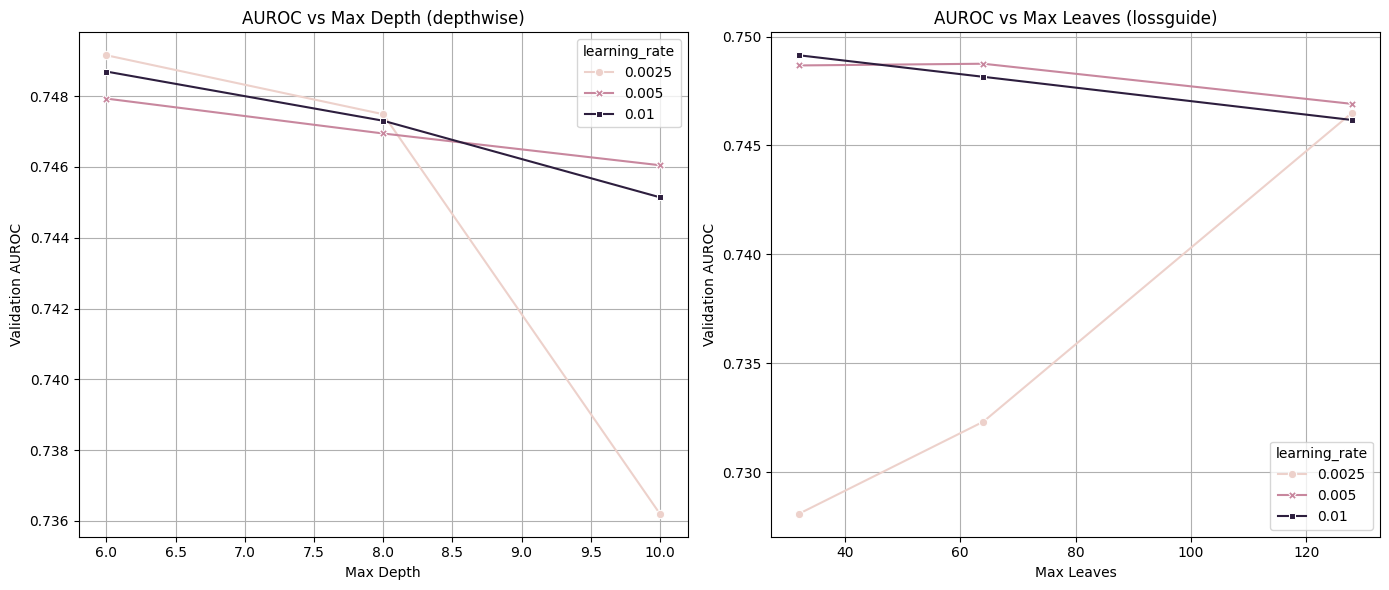

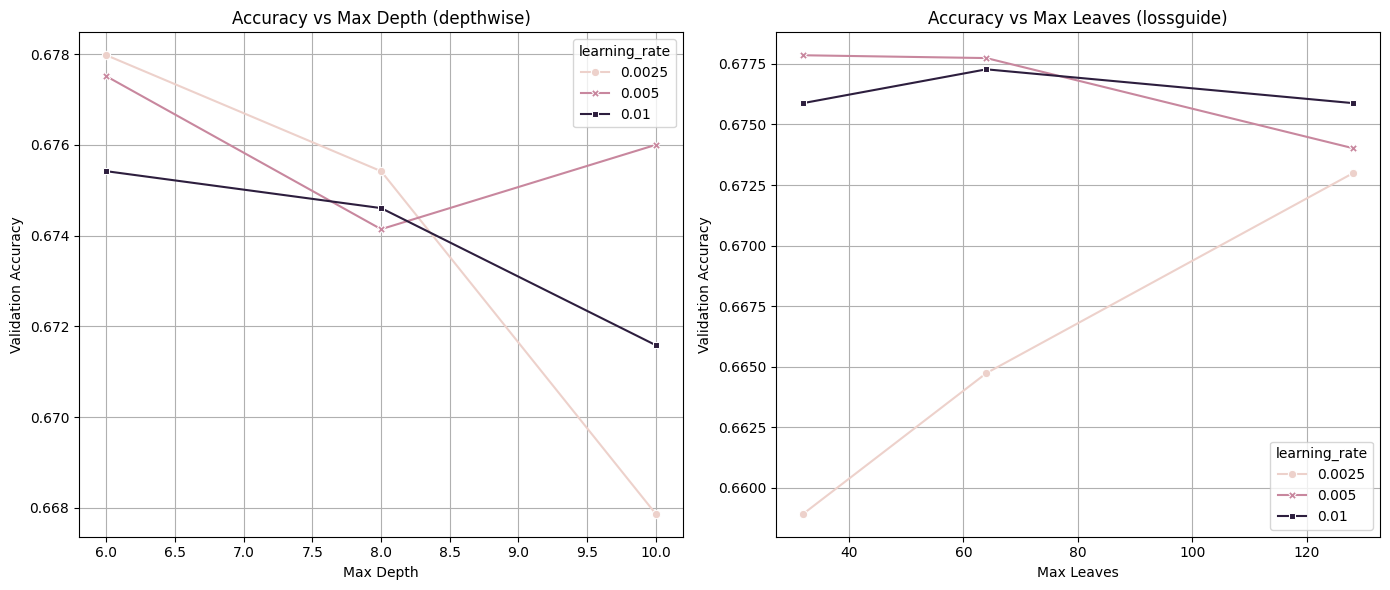

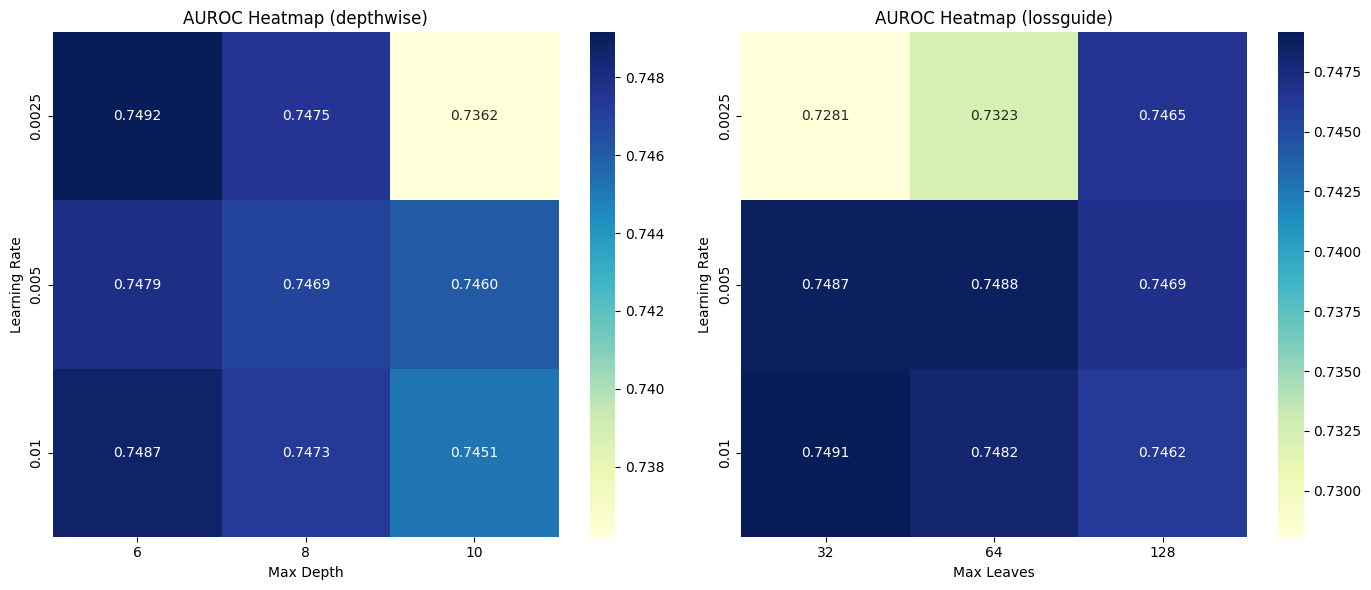

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.read_csv("xgb_gridsearch_results.csv")

df_lossguide = df_results[df_results['grow_policy'] == 'lossguide']
df_depthwise = df_results[df_results['grow_policy'] == 'depthwise']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_depthwise,
    x='complexity',
    y='auc',
    hue='learning_rate',
    style='learning_rate',
    markers=True,
    dashes=False
)
plt.title("AUROC vs Max Depth (depthwise)")
plt.xlabel("Max Depth")
plt.ylabel("Validation AUROC")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_lossguide,
    x='complexity',
    y='auc',
    hue='learning_rate',
    style='learning_rate',
    markers=True,
    dashes=False
)
plt.title("AUROC vs Max Leaves (lossguide)")
plt.xlabel("Max Leaves")
plt.ylabel("Validation AUROC")
plt.grid(True)

plt.tight_layout()
plt.savefig("auc_lineplots.png", dpi=300)
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_depthwise,
    x='complexity',
    y='accuracy',
    hue='learning_rate',
    style='learning_rate',
    markers=True,
    dashes=False
)
plt.title("Accuracy vs Max Depth (depthwise)")
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_lossguide,
    x='complexity',
    y='accuracy',
    hue='learning_rate',
    style='learning_rate',
    markers=True,
    dashes=False
)
plt.title("Accuracy vs Max Leaves (lossguide)")
plt.xlabel("Max Leaves")
plt.ylabel("Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("accuracy_lineplots.png", dpi=300)
plt.show()

pivot_lossguide = df_lossguide.pivot_table(
    index='learning_rate',
    columns='complexity',
    values='auc',
    aggfunc='max'
)
pivot_depthwise = df_depthwise.pivot_table(
    index='learning_rate',
    columns='complexity',
    values='auc',
    aggfunc='max'
)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(pivot_depthwise, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("AUROC Heatmap (depthwise)")
plt.ylabel("Learning Rate")
plt.xlabel("Max Depth")

plt.subplot(1, 2, 2)
sns.heatmap(pivot_lossguide, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("AUROC Heatmap (lossguide)")
plt.ylabel("Learning Rate")
plt.xlabel("Max Leaves")

plt.tight_layout()
plt.savefig("auc_heatmaps.png", dpi=300)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.read_csv("xgb_gridsearch_results.csv")

    'min_child_weight',
    'subsample',
    'colsample_bytree',
    'reg_alpha',
    'reg_lambda'
]

for param in param_list:
    if param not in df_results.columns:
        print(f"Skipping {param} (not in dataframe)")
        continue

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df_results,
        x=param,
        y='auc',
        hue='learning_rate',
        style='learning_rate',
        markers=True,
        dashes=False
    )
    plt.title(f"AUROC vs {param}")
    plt.xlabel(param)
    plt.ylabel("Validation AUROC")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"auc_vs_{param}.png", dpi=300)
    plt.close()

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt

PATCH_VER = "15.13"

synergy_score = np.load("synergy_score-" + PATCH_VER + ".npy")
counter_score = np.load("counter_score-" + PATCH_VER + ".npy")

df = pd.read_csv("COMBINED_MATCHSTATS-15.13.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    return np.mean([synergy_score[team[i]][team[j]] for i in range(5) for j in range(i + 1, 5)])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

def lane_counter(blue_team, red_team):
    result = [0] * 5
    for role_id in range(5):
        blue = [c for c, r in blue_team if r == role_id]
        red = [c for c, r in red_team if r == role_id]
        if blue and red:
            result[role_id] = counter_score[blue[0]][red[0]]
    return result

features = []
labels = []

for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)
        lane_counters = lane_counter(blue_team, red_team)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        flat_feats += lane_counters
        features.append(flat_feats)
        labels.append(label)

        lane_counters_flip = lane_counter(red_team, blue_team)
        flat_feats_flip = []
        for champ_id, role_id in red_team + blue_team:
            flat_feats_flip.extend([champ_id, role_id])
        flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
        flat_feats_flip += lane_counters_flip
        features.append(flat_feats_flip)
        labels.append(1 - label)

X = np.array(features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.0025,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 10,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 2.0,
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'grow_policy': 'depthwise',
    'max_depth': 6,
    'max_leaves': 0
}

eval_result = {}

booster = xgb.train(
    params,
    dtrain,
    num_boost_round=20000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    evals_result=eval_result,
    verbose_eval=True
)

booster.save_model("xgb_champion_model-15.13.json")

val_preds = booster.predict(dval)
val_binary = (val_preds > 0.5).astype(int)

acc = accuracy_score(y_val, val_binary)
auc = roc_auc_score(y_val, val_preds)
best_iter = booster.best_iteration

print("✅ Final Model Results")
print(f"   → Accuracy:        {acc:.4f}")
print(f"   → Validation AUROC:{auc:.4f}")
print(f"   → Best Iteration:  {best_iter}")

[0]	validation-auc:0.70947
[1]	validation-auc:0.71306
[2]	validation-auc:0.71904
[3]	validation-auc:0.72097
[4]	validation-auc:0.72233
[5]	validation-auc:0.72220
[6]	validation-auc:0.72367
[7]	validation-auc:0.72381
[8]	validation-auc:0.72686
[9]	validation-auc:0.72938
[10]	validation-auc:0.72951
[11]	validation-auc:0.72919
[12]	validation-auc:0.72888
[13]	validation-auc:0.72862
[14]	validation-auc:0.72840
[15]	validation-auc:0.72808
[16]	validation-auc:0.72769
[17]	validation-auc:0.72809
[18]	validation-auc:0.72810
[19]	validation-auc:0.72811
[20]	validation-auc:0.72818
[21]	validation-auc:0.72799
[22]	validation-auc:0.72873
[23]	validation-auc:0.72856
[24]	validation-auc:0.72853
[25]	validation-auc:0.72840
[26]	validation-auc:0.72832
[27]	validation-auc:0.72820
[28]	validation-auc:0.72810
[29]	validation-auc:0.72807
[30]	validation-auc:0.72822
[31]	validation-auc:0.72812
[32]	validation-auc:0.72818
[33]	validation-auc:0.72867
[34]	validation-auc:0.72856
[35]	validation-auc:0.72867
[3

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
from tqdm import tqdm

synergy_score = np.load("synergy_score-15.13.npy")
counter_score = np.load("counter_score-15.13.npy")

df = pd.read_csv("COMBINED_MATCHSTATS-15.13.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

import xgboost as xgb

model = xgb.XGBClassifier()
model.load_model("xgb_champion_model-15.13.json")

def average_synergy(team):
    pairs = [(i, j) for i in range(5) for j in range(i+1, 5)]
    return np.mean([synergy_score[team[i]][team[j]] for i, j in pairs])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

def predict_winrate(blue_team, red_team):
    blue_ids = [champion_to_idx[c] for c, r in blue_team]
    red_ids = [champion_to_idx[c] for c, r in red_team]
    blue_roles = [role_to_idx[r] for c, r in blue_team]
    red_roles = [role_to_idx[r] for c, r in red_team]

    blue_synergy = average_synergy(blue_ids)
    red_synergy = average_synergy(red_ids)
    blue_vs_red = average_counter(blue_ids, red_ids)
    red_vs_blue = average_counter(red_ids, blue_ids)

    lane_counters = [0] * 5
    for role_id in range(5):
        blue_champ = [c for c, r in zip(blue_ids, blue_roles) if r == role_id]
        red_champ = [c for c, r in zip(red_ids, red_roles) if r == role_id]
        if blue_champ and red_champ:
            lane_counters[role_id] = counter_score[blue_champ[0]][red_champ[0]]

    flat_feats = []
    for champ_id, role_id in zip(blue_ids + red_ids, blue_roles + red_roles):
        flat_feats.extend([champ_id, role_id])
    flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
    flat_feats += lane_counters
    x_blue = np.array(flat_feats).reshape(1, -1)

    lane_counters_flip = [0] * 5
    for role_id in range(5):
        red_champ = [c for c, r in zip(red_ids, red_roles) if r == role_id]
        blue_champ = [c for c, r in zip(blue_ids, blue_roles) if r == role_id]
        if red_champ and blue_champ:
            lane_counters_flip[role_id] = counter_score[red_champ[0]][blue_champ[0]]

    flat_feats_flip = []
    for champ_id, role_id in zip(red_ids + blue_ids, red_roles + blue_roles):
        flat_feats_flip.extend([champ_id, role_id])
    flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
    flat_feats_flip += lane_counters_flip
    x_red = np.array(flat_feats_flip).reshape(1, -1)

    prob_blue = model.predict_proba(x_blue)[0][1]
    prob_red = model.predict_proba(x_red)[0][1]
    return prob_blue, prob_red

def estimate_champion_value(champion_name, role, model, all_champions, predict_winrate, roles, n_samples=50, neutral_champion="Garen"):
    impacts = []
    role_index = roles.index(role)
    for _ in range(n_samples):
        allies = random.sample([c for c in all_champions if c != champion_name and c != neutral_champion], 4)
        enemies = random.sample([c for c in all_champions if c != champion_name and c != neutral_champion], 5)
        ally_roles = roles[:role_index] + roles[role_index+1:]
        blue_team = [(champion_name, role)] + [(a, r) for a, r in zip(allies, ally_roles)]
        red_team = [(e, r) for e, r in zip(enemies, roles)]
        try:
            base_win, _ = predict_winrate(blue_team, red_team)
            neutral_team = [(neutral_champion, role)] + [(a, r) for a, r in zip(allies, ally_roles)]
            neutral_win, _ = predict_winrate(neutral_team, red_team)
            impacts.append(base_win - neutral_win)
        except:
            continue
    return np.mean(impacts) if impacts else 0.0

def single_champion_impact(args):
    champion, role, model, all_champions, predict_winrate, roles, n_samples, neutral_champion = args
    try:
        impact = estimate_champion_value(champion, role, model, all_champions, predict_winrate, roles, n_samples, neutral_champion)
        return role, champion, impact
    except:
        return role, champion, 0.0

def build_champion_tierlist_filtered(model, df, champion_to_idx, roles, predict_winrate, threshold=50, n_samples=50):
    pair_counts = Counter()
    for _, row in df.iterrows():
        champ = row['championName']
        role = row['role']
        pair_counts[(champ, role)] += 1

    all_champions = list(champion_to_idx.keys())
    tierlist = defaultdict(dict)
    tasks = []

    for role in roles:
        for champion in all_champions:
            if pair_counts.get((champion, role), 0) < threshold:
                continue
            tasks.append((champion, role, model, all_champions, predict_winrate, roles, n_samples, "Garen"))

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_champion_impact, args) for args in tasks]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating champions"):
            role, champion, impact = future.result()
            tierlist[role][champion] = impact

    for role in roles:
        print(f"✅ Finished evaluating {role}")
    return tierlist

def print_tierlist(tierlist, roles, top_k=None):
    for role in roles:
        print(f"\n===== {role} TIER LIST =====")
        sorted_champs = sorted(tierlist[role].items(), key=lambda x: x[1], reverse=True)
        if top_k is not None:
            sorted_champs = sorted_champs[:top_k]
        for i, (champ, val) in enumerate(sorted_champs):
            print(f"{i+1}. {champ:15s} ({val:+.4f})")

random.seed(0)
np.random.seed(0)
tierlist = build_champion_tierlist_filtered(
    model,
    df,
    champion_to_idx,
    roles,
    predict_winrate,
    threshold=73,
    n_samples=1000
)

print_tierlist(tierlist, roles, top_k=None)

import pandas as pd

def save_tierlist_to_csv(tierlist, filepath="tierlist.csv"):
    rows = []
    for role, champs in tierlist.items():
        for champ, score in champs.items():
            rows.append({"Role": role, "Champion": champ, "ImpactScore": score})
    df = pd.DataFrame(rows)
    df.sort_values(by=["Role", "ImpactScore"], ascending=[True, False], inplace=True)
    df.to_csv(filepath, index=False)

save_tierlist_to_csv(tierlist, "tierlist-15.13.csv")

/tmp/ipykernel_5046/3762367945.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("COMBINED_MATCHSTATS-15,13.csv")
Evaluating champions:   0%|          | 0/390 [00:05<?, ?it/s]


In [ ]:
import pandas as pd

df = pd.read_csv("COMBINED_MATCHSTATS-15.13.csv")

games = df[(df["championName"].str.lower() == "zyra") & (df["role"].str.upper() == "MIDDLE")]
num_games = games["match_id"].nunique()

print(f"Smolder played top in {num_games} unique games.")

Smolder played top in 33 unique games.


In [ ]:
import numpy as np
import xgboost as xgb

blue_team = [("Malphite", "TOP"), ("Nocturne", "JUNGLE"), ("Lissandra", "MIDDLE"), ("Lucian", "BOTTOM"), ("Neeko", "UTILITY")]
red_team = [("Sett", "TOP"), ("XinZhao", "JUNGLE"), ("Seraphine", "MIDDLE"), ("Corki", "BOTTOM"), ("Rell", "UTILITY")]

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_list = list(champion_to_idx.keys())
dummy_champion_id = len(champion_list)

blue_team_ids = [(champion_to_idx.get(c, dummy_champion_id), role_to_idx[r]) for c, r in blue_team]
red_team_ids = [(champion_to_idx.get(c, dummy_champion_id), role_to_idx[r]) for c, r in red_team]

def lane_counter(blue_team, red_team):
    result = [0] * 5
    for role_id in range(5):
        blue = [c for c, r in blue_team if r == role_id]
        red = [c for c, r in red_team if r == role_id]
        if blue and red:
            result[role_id] = counter_score[blue[0]][red[0]]
    return result

blue_ids = [c for c, _ in blue_team_ids]
red_ids = [c for c, _ in red_team_ids]

blue_synergy = average_synergy(blue_ids)
red_synergy = average_synergy(red_ids)
blue_vs_red = average_counter(blue_ids, red_ids)
red_vs_blue = average_counter(red_ids, blue_ids)
lane_counters = lane_counter(blue_team_ids, red_team_ids)

flat_feats = []
for champ_id, role_id in blue_team_ids + red_team_ids:
    flat_feats.extend([champ_id, role_id])
flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
flat_feats += lane_counters
test_X = np.array(flat_feats).reshape(1, -1)

model = xgb.XGBClassifier()
model.load_model("xgb_champion_model-15.12.json")

pred_blue_win = model.predict_proba(test_X)[0,1]
pred_red_win = 1 - pred_blue_win

# print(f"Blue winrate: {pred_blue_win:.4f}")
# print(f"Red winrate: {pred_red_win:.4f}")

influences = {}
for idx, (champ_name, role) in enumerate(blue_team + red_team):
    mod_feats = flat_feats.copy()
    mod_feats[idx*2] = dummy_champion_id
    test_X_mod = np.array(mod_feats).reshape(1, -1)
    pred_mod = model.predict_proba(test_X_mod)[0,1]
    influence = abs(pred_blue_win - pred_mod)
    influences[champ_name] = influence

print(f"{blue_emoji} BLUE TEAM (winrate {pred_blue_win * 100:.2f}%):")
for champ, role in blue_team:
    infl = influences.get(champ, 0)
    print(f"{champ} ({role}): {infl:.4f}")

print(f"{red_emoji} RED TEAM (winrate {pred_red_win * 100:.2f}%):")
for champ, role in red_team:
    infl = influences.get(champ, 0)
    print(f"{champ} ({role}): {infl:.4f}")



🔵 BLUE TEAM (winrate 14.09%):
Malphite (TOP): 0.0106
Nocturne (JUNGLE): 0.0230
Lissandra (MIDDLE): 0.0097
Lucian (BOTTOM): 0.0044
Neeko (UTILITY): 0.0145
🔴 RED TEAM (winrate 85.91%):
Sett (TOP): 0.0000
XinZhao (JUNGLE): 0.0016
Seraphine (MIDDLE): 0.0438
Corki (BOTTOM): 0.0094
Rell (UTILITY): 0.0043


In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score

na_df = pd.read_csv("CHALLENGER_MATCHSTATS.csv")
na_df = na_df.dropna(subset=["championName", "role", "win"])

na_matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in na_df.iterrows():
    match_id = row['match_id']
    champ_name = row['championName']
    if champ_name not in champion_to_idx:
        continue
    champ_id = champion_to_idx[champ_name]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        na_matches[match_id][team].append((champ_id, role_id))
    if na_matches[match_id]['win'] is None and team == 'blue':
        na_matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    pairs = [(i, j) for i in range(5) for j in range(i+1, 5)]
    return np.mean([synergy_score[team[i]][team[j]] for i, j in pairs])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

def lane_counter(blue_team, red_team):
    result = [0] * 5
    for role_id in range(5):
        blue = [c for c, r in blue_team if r == role_id]
        red = [c for c, r in red_team if r == role_id]
        if blue and red:
            result[role_id] = counter_score[blue[0]][red[0]]
    return result

na_features = []
na_labels = []
match_ids = []

for match_id, match in na_matches.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)
        lane_counters = lane_counter(blue_team, red_team)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        flat_feats += lane_counters
        na_features.append(flat_feats)
        na_labels.append(label)
        match_ids.append(match_id)

X_na = np.array(na_features)
y_na = np.array(na_labels)

na_preds = model.predict_proba(X_na)[:, 1]
na_binary = (na_preds > 0.5).astype(int)

print(f"\nNA Data Accuracy: {accuracy_score(y_na, na_binary):.4f}")
print(f"NA Data AUC: {roc_auc_score(y_na, na_preds):.4f}\n")

for i, (match_id, true, prob) in enumerate(zip(match_ids, y_na, na_preds)):
    pred = int(prob > 0.5)
    correct = "✅" if pred == true else "❌"
    print(f"Match {i+1:03d} (ID {match_id}): True={true} | Pred={pred} | Prob={prob:.4f} | {correct}")


NA Data Accuracy: 0.6539
NA Data AUC: 0.7173

Match 001 (ID NA1_5314716909): True=0 | Pred=1 | Prob=0.5059 | ❌
Match 002 (ID NA1_5314481303): True=1 | Pred=1 | Prob=0.6063 | ✅
Match 003 (ID NA1_5314463601): True=1 | Pred=1 | Prob=0.8480 | ✅
Match 004 (ID NA1_5314458118): True=1 | Pred=1 | Prob=0.7691 | ✅
Match 005 (ID NA1_5314451837): True=0 | Pred=0 | Prob=0.2186 | ✅
Match 006 (ID NA1_5314440882): True=0 | Pred=0 | Prob=0.2375 | ✅
Match 007 (ID NA1_5314400100): True=0 | Pred=1 | Prob=0.6048 | ❌
Match 008 (ID NA1_5314370641): True=1 | Pred=0 | Prob=0.4994 | ❌
Match 009 (ID NA1_5314345179): True=0 | Pred=0 | Prob=0.4138 | ✅
Match 010 (ID NA1_5314305530): True=1 | Pred=0 | Prob=0.2491 | ❌
Match 011 (ID NA1_5314271162): True=1 | Pred=1 | Prob=0.7602 | ✅
Match 012 (ID NA1_5314230177): True=0 | Pred=0 | Prob=0.2439 | ✅
Match 013 (ID NA1_5314009161): True=0 | Pred=0 | Prob=0.4808 | ✅
Match 014 (ID NA1_5313983004): True=1 | Pred=1 | Prob=0.7539 | ✅
Match 015 (ID NA1_5313956954): True=0 | Pre

In [ ]:
na_df = pd.read_csv("na_match_stats.csv")
na_df = na_df.dropna(subset=["championName", "role", "win"])

na_matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in na_df.iterrows():
    match_id = row['match_id']
    champ_name = row['championName']
    role_name = row['role']
    if champ_name not in champion_to_idx or role_name not in role_to_idx:
        continue
    champ_id = champion_to_idx[champ_name]
    role_id = role_to_idx[role_name]
    team = 'blue' if row['teamId'] == 100 else 'red'
    na_matches[match_id][team].append((champ_id, role_id))
    if na_matches[match_id]['win'] is None and team == 'blue':
        na_matches[match_id]['win'] = int(row['win'])

na_features = []
na_labels = []
match_ids = []

for match_id, match in na_matches.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]

        na_features.append(flat_feats)
        na_labels.append(label)
        match_ids.append(match_id)

X_na = np.array(na_features)
y_na = np.array(na_labels)

na_preds = model.predict_proba(X_na)[:, 1]
na_binary = (na_preds > 0.5).astype(int)

print(f"NA Accuracy: {accuracy_score(y_na, na_binary):.4f}")
print(f"NA AUC: {roc_auc_score(y_na, na_preds):.4f}")

for match_id, true, pred, conf in zip(match_ids, y_na, na_binary, na_preds):
    mark = "✅" if int(true) == int(pred) else "❌"
    pred_label = "Blue" if pred == 1 else "Red"
    true_label = "Blue" if true == 1 else "Red"
    print(f"Match {match_id}: True = {true_label}, Predicted = {pred_label}, Confidence = {conf:.4f} {mark}")


✅ NA Accuracy: 0.6052
✅ NA AUC: 0.6398
Match NA1_5312517663: True = Red, Predicted = Red, Confidence = 0.3302 ✅
Match NA1_5312416990: True = Red, Predicted = Blue, Confidence = 0.5261 ❌
Match NA1_5312379651: True = Red, Predicted = Blue, Confidence = 0.5110 ❌
Match NA1_5312352561: True = Blue, Predicted = Red, Confidence = 0.3236 ❌
Match NA1_5312329447: True = Blue, Predicted = Blue, Confidence = 0.6779 ✅
Match NA1_5312309925: True = Blue, Predicted = Blue, Confidence = 0.6677 ✅
Match NA1_5311914571: True = Red, Predicted = Red, Confidence = 0.3662 ✅
Match NA1_5311884519: True = Red, Predicted = Blue, Confidence = 0.5452 ❌
Match NA1_5311848028: True = Red, Predicted = Red, Confidence = 0.1283 ✅
Match NA1_5311814906: True = Blue, Predicted = Blue, Confidence = 0.7041 ✅
Match NA1_5311773674: True = Red, Predicted = Red, Confidence = 0.3549 ✅
Match NA1_5311637645: True = Blue, Predicted = Red, Confidence = 0.0294 ❌
Match NA1_5311244561: True = Red, Predicted = Red, Confidence = 0.1136 ✅
M

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb

synergy_score = np.load("synergy_score.npy")
counter_score = np.load("counter_score.npy")

df = pd.read_csv("COMBINED_MATCHSTATS.csv")
df = df.dropna(subset=["championName", "role", "win"])

roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
role_to_idx = {r: i for i, r in enumerate(roles)}
champion_to_idx = {name: i for i, name in enumerate(df['championName'].unique())}
idx_to_champion = {i: name for name, i in champion_to_idx.items()}
num_champions = len(champion_to_idx)

champion_tags = {}
for champ, idx in champion_to_idx.items():
    champ_lower = champ.lower()
    tag = {
        'range': 'melee' if any(w in champ_lower for w in ['garen', 'amumu', 'lee', 'xin', 'jarvan']) else 'ranged',
        'damage': 'AD' if any(w in champ_lower for w in ['lucian', 'vayne', 'lee', 'zed', 'yasuo']) else 'AP',
        'engage': int(any(w in champ_lower for w in ['amumu', 'malphite', 'leona', 'jarvan'])),
        'peel': int(any(w in champ_lower for w in ['janna', 'lulu', 'nami', 'braum'])),
        'tank': int(any(w in champ_lower for w in ['amumu', 'leona', 'malphite', 'shen', 'braum']))
    }
    champion_tags[idx] = tag

def team_composition_features(team_ids):
    melee = ranged = ap = ad = engage = peel = tank = 0
    for cid in team_ids:
        tag = champion_tags.get(cid, {})
        if tag.get('range') == 'melee':
            melee += 1
        elif tag.get('range') == 'ranged':
            ranged += 1
        if tag.get('damage') == 'AP':
            ap += 1
        elif tag.get('damage') == 'AD':
            ad += 1
        engage += tag.get('engage', 0)
        peel += tag.get('peel', 0)
        tank += tag.get('tank', 0)
    return [melee, ranged, ap, ad, int(engage > 0), int(peel > 0), int(tank > 0)]

matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in df.iterrows():
    match_id = row['match_id']
    champ_id = champion_to_idx[row['championName']]
    role_id = role_to_idx.get(row['role'], -1)
    team = 'blue' if row['teamId'] == 100 else 'red'
    if role_id != -1:
        matches[match_id][team].append((champ_id, role_id))
    if matches[match_id]['win'] is None and team == 'blue':
        matches[match_id]['win'] = int(row['win'])

def average_synergy(team):
    pairs = [(i, j) for i in range(5) for j in range(i+1, 5)]
    return np.mean([synergy_score[team[i]][team[j]] for i, j in pairs])

def average_counter(offense, defense):
    return np.mean([counter_score[o][d] for o in offense for d in defense])

features = []
labels = []

for match in matches.values():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)

        blue_comp = team_composition_features(blue_ids)
        red_comp = team_composition_features(red_ids)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        flat_feats += blue_comp + red_comp
        features.append(flat_feats)
        labels.append(label)

        flat_feats_flip = []
        for champ_id, role_id in red_team + blue_team:
            flat_feats_flip.extend([champ_id, role_id])
        flat_feats_flip += [red_synergy, blue_synergy, red_vs_blue, blue_vs_red]
        flat_feats_flip += red_comp + blue_comp
        features.append(flat_feats_flip)
        labels.append(1 - label)

X = np.array(features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(X_train, y_train)

val_preds = model.predict_proba(X_val)[:, 1]
val_binary = (val_preds > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_val, val_binary):.4f}")
print(f"AUC: {roc_auc_score(y_val, val_preds):.4f}")

c:\Users\Stella\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Accuracy: 0.7344
✅ AUC: 0.8168


In [ ]:
na_df = pd.read_csv("CHALLENGER_MATCHSTATS.csv")
na_df = na_df.dropna(subset=["championName", "role", "win"])

na_matches = defaultdict(lambda: {'blue': [], 'red': [], 'win': None})
for _, row in na_df.iterrows():
    match_id = row['match_id']
    champ_name = row['championName']
    role_name = row['role']
    if champ_name not in champion_to_idx or role_name not in role_to_idx:
        continue
    champ_id = champion_to_idx[champ_name]
    role_id = role_to_idx[role_name]
    team = 'blue' if row['teamId'] == 100 else 'red'
    na_matches[match_id][team].append((champ_id, role_id))
    if na_matches[match_id]['win'] is None and team == 'blue':
        na_matches[match_id]['win'] = int(row['win'])

na_features = []
na_labels = []
match_ids = []

for match_id, match in na_matches.items():
    if len(match['blue']) == 5 and len(match['red']) == 5:
        blue_team = match['blue']
        red_team = match['red']
        blue_ids = [c for c, _ in blue_team]
        red_ids = [c for c, _ in red_team]
        label = match['win']

        blue_synergy = average_synergy(blue_ids)
        red_synergy = average_synergy(red_ids)
        blue_vs_red = average_counter(blue_ids, red_ids)
        red_vs_blue = average_counter(red_ids, blue_ids)

        blue_comp = team_composition_features(blue_ids)
        red_comp = team_composition_features(red_ids)

        flat_feats = []
        for champ_id, role_id in blue_team + red_team:
            flat_feats.extend([champ_id, role_id])
        flat_feats += [blue_synergy, red_synergy, blue_vs_red, red_vs_blue]
        flat_feats += blue_comp + red_comp

        na_features.append(flat_feats)
        na_labels.append(label)
        match_ids.append(match_id)

X_na = np.array(na_features)
y_na = np.array(na_labels)

na_preds = model.predict_proba(X_na)[:, 1]
na_binary = (na_preds > 0.5).astype(int)

print(f"NA Accuracy: {accuracy_score(y_na, na_binary):.4f}")
print(f"NA AUC: {roc_auc_score(y_na, na_preds):.4f}")

for match_id, true, pred, conf in zip(match_ids, y_na, na_binary, na_preds):
    mark = "✅" if int(true) == int(pred) else "❌"
    pred_label = "Blue" if pred == 1 else "Red"
    true_label = "Blue" if true == 1 else "Red"
    print(f"Match {match_id}: True = {true_label}, Predicted = {pred_label}, Confidence = {conf:.4f} {mark}")

✅ NA Accuracy: 0.6585
✅ NA AUC: 0.7143
Match NA1_5314716909: True = Red, Predicted = Blue, Confidence = 0.6501 ❌
Match NA1_5314481303: True = Blue, Predicted = Blue, Confidence = 0.7050 ✅
Match NA1_5314463601: True = Blue, Predicted = Blue, Confidence = 0.9499 ✅
Match NA1_5314458118: True = Blue, Predicted = Blue, Confidence = 0.7958 ✅
Match NA1_5314451837: True = Red, Predicted = Red, Confidence = 0.2131 ✅
Match NA1_5314440882: True = Red, Predicted = Red, Confidence = 0.2841 ✅
Match NA1_5314400100: True = Red, Predicted = Blue, Confidence = 0.6667 ❌
Match NA1_5314370641: True = Blue, Predicted = Blue, Confidence = 0.5718 ✅
Match NA1_5314345179: True = Red, Predicted = Red, Confidence = 0.3549 ✅
Match NA1_5314305530: True = Blue, Predicted = Red, Confidence = 0.1281 ❌
Match NA1_5314271162: True = Blue, Predicted = Blue, Confidence = 0.8789 ✅
Match NA1_5314230177: True = Red, Predicted = Red, Confidence = 0.0928 ✅
Match NA1_5314009161: True = Red, Predicted = Red, Confidence = 0.4626 ✅